In [0]:
%pip install scikit-learn==1.5.1
%pip install matplotlib
%pip install pandas==2.2.3

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
%run ./utils/user_defined_functions

In [0]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import os
import re
from unidecode import unidecode
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_predict
import base64
from io import BytesIO

## Utils functions used in notebooks

No such comm: LSP_COMM_ID
No such comm: LSP_COMM_ID


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
catalog_path = f"/Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/"

In [0]:
df_complete = pd.read_csv(f"/Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/data_cleaning/data_clean_complete_v06.csv", sep=";")
#df_complete = pd.read_csv(f"/Volumes/dev_mlops/hr_turnover/data_cleaning/data_clean_complete_v06.csv", sep=";")

## Lettura df

In [0]:
years = ['2020', '2021', '2022', '2023', '2024']

In [0]:
!pip install openpyxl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:

def read_file(year, row_count_messages):
    """
    Legge il file Excel relativo all'anno specificato, applica le trasformazioni sui nomi delle colonne,
    rinomina e converte i tipi, filtra i dati secondo le regole definite e restituisce il DataFrame.
    """
    file_path = f"/Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/input/employee_data/{year}_DS_v05.xlsx" 
    
    df_y = pd.read_excel(file_path, sheet_name='Report')
    
    df_y.columns = [simplify_string(col) for col in df_y.columns]
    
    df_y = df_y.rename(columns={
        'person_id': 'user_sys_id',
        'year': 'reference_year',
        'employment_details_termination_type': 'voluntary_involuntary_turnover'
    })
    
    df_y['reference_year'] = year
    df_y['user_sys_id'] = df_y['user_sys_id'].astype(str)
    
    # Converti le colonne in base al tipo 
    df_y['hr_manager_other_relationships_user_id'] = df_y['hr_manager_other_relationships_user_id'].astype(str)
    df_y['user_employee_id'] = pd.to_numeric(df_y['user_employee_id'], errors='coerce')
    df_y['salary_review'] = pd.to_numeric(df_y['salary_review'], errors='coerce')
    df_y['check_comp_increase'] = pd.to_numeric(df_y['check_comp_increase'], errors='coerce')
    df_y['check_same_country'] = df_y['check_same_country'].astype(bool)
    
    # esclude le righe con country_region uguale a 'Japan'
    df_y = df_y[df_y['country_region'] != 'Japan']
    
    # Converte la colonna date_of_birth in stringa
    df_y['date_of_birth'] = df_y['date_of_birth'].astype(str)
    
    # Rimuove la colonna 'compensation_changes' se presente
    if 'compensation_changes' in df_y.columns:
        df_y = df_y.drop(columns=['compensation_changes'])
            # Aggiungi la stringa con il numero di righe e l'anno alla lista
    row_count_messages.append(f'[{years.index(year)+1}] "{df_y.shape[0]} rows loaded from year {year}"')

    # Stampa il numero di righe caricate
    print(f"{df_y.shape[0]} rows loaded from year {year}")
    
    return df_y, row_count_messages

row_count_messages = []
# Inizialmente df è vuoto e i dati verranno aggregati per ogni anno in 'years'
df = pd.DataFrame()
for y in years:
    df_year, row_count_messages = read_file(y, row_count_messages)
    if 'person_id_vlookup_' in df_year.columns:
        df_year['person_id_vlookup_'] = df_year['person_id_vlookup_'].astype(str)
    df = pd.concat([df, df_year], ignore_index=True)

# Count file da mettere nell'html finale
row_count_string = " ".join(row_count_messages)

# Definizione dei gruppi di paesi per ciascuna regione
countries_semea    = ["France", "Italy", "Spain", "Greece", "South Africa"]
countries_ncee     = ["United Kingdom", "Germany", "Russian Federation", "Belgium", "Switzerland", "Ukraine", "Austria"]
countries_apac     = ["Australia", "Singapore", "Korea (the Republic of)", "China", "India", "New Zealand"]
countries_americas = ["Jamaica", "United States", "Mexico", "Brazil", "Canada", "Argentina", "Peru"]

# Creazione della colonna 'geographical_region' in base al valore di 'country_region'
conditions = [
    df['country_region'].isin(countries_semea),
    df['country_region'].isin(countries_ncee),
    df['country_region'].isin(countries_apac),
    df['country_region'].isin(countries_americas)
]
choices = ['Semea', 'Ncee', 'Apac', 'Americas']
df['geographical_region'] = np.select(conditions, choices, default='Unknown')

# Estrae i dipendenti expatriati in entrata e in uscita, impostando expat = True
df_expat_in = df[(df['employee_category'] == 'Expat IN') & (df['employee_status'].isin(['Active', 'On Leave']))].copy()
df_expat_in['expat'] = True

df_expat_out = df[(df['employee_category'] == 'Expat OUT') & (df['employee_status'] == 'Terminated')].copy()
df_expat_out['expat'] = True

# Filtra il DataFrame principale
df = df[(df['employee_status'] != 'Dormant') &
        (df['contract_type'] == 'Permanent') &
        (df['employee_category'] == 'Employee')].copy()
df['expat'] = False

# Aggiunge le righe degli expat (sia in entrata che in uscita)
df = pd.concat([df, df_expat_in, df_expat_out], ignore_index=True)

# Mappa lo status: 'Active' e 'On Leave' diventano 'onboard', altrimenti 'terminated'
df['employee_status'] = np.where(df['employee_status'].isin(['Active', 'On Leave']),
                                 'onboard', 'terminated')

# Calcola la colonna 'stay'
df['stay'] = np.where(df['employee_status'] == 'onboard', "TRUE",
                      np.where((df['voluntary_involuntary_turnover'] != "Involuntary") | (df['voluntary_involuntary_turnover'].isna()),
                               "TRUE", "FALSE"))
# Mantiene solo le righe dove stay è "TRUE"
df = df[df['stay'] == "TRUE"].copy()

# Rimuove le colonne non più necessarie
df.drop(columns=['voluntary_involuntary_turnover', 'stay'], inplace=True, errors='ignore')

# Rimuove i dipendenti in pensione
retired_reasons = ["ERT-Early / Voluntary Retirement", "NRT-Normal Retirement", "VOLRET-Voluntary Retirment"]
df = df[~df['event_reason'].isin(retired_reasons)].copy()
df.drop(columns=['event', 'event_reason', 'event_date'], inplace=True, errors='ignore')

# Rimuove i blue collars e le posizioni troppo alte
df = df[~df['global_leveling'].isin(['Blue Collars', 'Senior Executive', 'Officer'])].copy()

4825 rows loaded from year 2020
4884 rows loaded from year 2021
5436 rows loaded from year 2022
5236 rows loaded from year 2023
6226 rows loaded from year 2024


In [0]:
# Lista delle colonne da convertire in interi
# cols_to_convert = ['position', 'manager_user_sys_id', 'reference_year', 'tenure_in_the_position_days', 'age','tenure', 'position_class_num', 'years_since_prom','wg_n' ,'gptw_camaraderie', 'gptw_credibility','gptw_fairness', 'gptw_pride' , 'gptw_respect', 'gptw_responders']

# # Converte i valori in interi per quelle colonne
# df_complete[cols_to_convert] = df_complete[cols_to_convert].apply(lambda x: x.fillna(pd.NA).astype('Int64'))

In [0]:
# Raggruppa e conta i dati
tab_match_country_gptw = (
    df_complete[df_complete['match_type'] == 'country']
    .groupby(['reference_year', 'country_region', 'job_function'])
    .size()
    .reset_index(name='count')
)
tab_match_country_gptw

,reference_year,country_region,job_function,count
0,2020,argentina,sm_mk_marketing,1
1,2020,australia,sc_lo_logistics_customer_service,2
2,2020,australia,sc_pl_planning,1
3,2020,australia,sc_qu_quality,3
4,2020,australia,sf_hr_hr,1
...,...,...,...,...
161,2022,united_states,sc_lo_logistics_customer_service,4
162,2022,united_states,sc_pr_procurement,2
163,2022,united_states,sc_rd_r_d,2
164,2022,united_states,sf_it_it,1


In [0]:
n_match_gptw_bycountry = tab_match_country_gptw['count'].sum()

In [0]:
tab_nas_gptw = (
    df_complete[df_complete.filter(like='gptw').isna().any(axis=1)]
    .groupby(['reference_year', 'country_region'])
    .size()
    .reset_index(name='count')
)
tab_nas_gptw

,reference_year,country_region,count
0,2020,new_zealand,1
1,2020,singapore,1
2,2021,korea_the_republic_of_,4
3,2021,new_zealand,1
4,2021,south_africa,6
5,2022,india,3
6,2022,korea_the_republic_of_,6
7,2022,new_zealand,2
8,2022,south_africa,7
9,2023,argentina,103


In [0]:
n_nas_gptw = tab_nas_gptw['count'].sum()

In [0]:
df_complete = df_complete.drop(columns=[
    'marital_status',  # too many unknown
    'education',       # too many unknown
    'match_type',
    'placement',
    'placement_ev',
    'plac_ev_new',
    'legal_entity',
    'group_management',
    'unit',
    'location',
    'cost_center',
    'org_layer',
    'job_area',
    'job_function',
    'job_family',
    'reference_job',
    'people_manager',
    'manager_user_sys_id',
    'expat',
    'position',
    'salary_review',
    'sal_rev_last_2y',
    'tenure',
    'recently_hired'
])

In [0]:
cols_to_simplify = df_complete.select_dtypes(include='object').columns.difference(['user_sys_id'])
df_complete[cols_to_simplify] = df_complete[cols_to_simplify].applymap(simplify_string)

/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198116-489056878:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_complete[cols_to_simplify] = df_complete[cols_to_simplify].applymap(simplify_string)


In [0]:
df_complete[df_complete.select_dtypes(include='object').columns] = (
    df_complete.select_dtypes(include='object').apply(lambda col: col.astype('category'))
)

In [0]:
# Converte global_leveling in un category ordinato con livelli specifici
df_complete['global_leveling'] = pd.Categorical(
    df_complete['global_leveling'],
    categories=[
        "professional",
        "specialist_gen_staff",
        "officer",
        "senior_professional",
        "executive",
        "senior_executive",
        "management",
        "senior_management"
    ],
    ordered=True  
)

In [0]:
df_complete = df_complete.rename(columns={
    'tenure_in_the_position_days': 'tenure_in_pos_days',
    'management_non_management': 'mgmt'
})
n_tot_employee = len(df_complete)
n_tot_employee

8727

In [0]:
df_complete['country_region'].value_counts()

country_region
italy                     1990
united_states             1056
france                     909
jamaica                    726
mexico                     496
australia                  433
brazil                     408
germany                    365
united_kingdom             344
canada                     273
russian_federation         256
argentina                  242
spain                      146
singapore                  130
india                      116
korea_the_republic_of_     102
belgium                    101
new_zealand                 91
south_africa                91
peru                        88
china                       85
greece                      83
switzerland                 77
ukraine                     64
austria                     55
Name: count, dtype: int64

## Standardize

In [0]:
def scale2(x, na_rm=False):
    if na_rm:
        x = x[~np.isnan(x)]  # Rimuove i NaN se na_rm è True
    return (x - np.mean(x)) / np.std(x)

In [0]:
# Seleziona tutte le colonne che contengono 'gptw' e rimuovi 'gptw_overall' e 'gptw_responders'
gptw_avg = df_complete.drop(columns=['gptw_overall', 'gptw_responders'])

# Calcola la media delle righe per le colonne che contengono 'gptw'
gptw_avg['avg_gptw_score'] = gptw_avg.filter(like='gptw', axis=1).mean(axis=1)

# Applica la funzione 'scale2' alla colonna 'avg_gptw_score' per standardizzarla
gptw_avg['avg_gptw_score'] = scale2(gptw_avg['avg_gptw_score'], na_rm=True)

# Se desideri che l'output sia solo la colonna 'avg_gptw_score':
gptw_avg = gptw_avg[['avg_gptw_score']]
gptw_avg

,avg_gptw_score
0,NaN
1,0.436334
2,NaN
3,-1.057701
4,NaN
...,...
8722,1.335969
8723,0.259621
8724,NaN
8725,-0.158067


In [0]:
# Lista delle colonne da convertire in interi
cols_to_convert = ['reference_year', 'tenure_in_pos_days', 'age','position_class_num', 'years_since_prom','wg_n' ,'gptw_camaraderie', 'gptw_credibility','gptw_fairness', 'gptw_pride' , 'gptw_respect', 'gptw_responders']

# Converte i valori in interi per quelle colonne
df_complete[cols_to_convert] = df_complete[cols_to_convert].apply(lambda x: x.fillna(pd.NA).astype('Int64'))

In [0]:
df_complete = df_complete.loc[:, ~df_complete.columns.str.contains('gptw')]

df_complete = pd.concat([df_complete, gptw_avg], axis=1)

In [0]:
# Applica la funzione di ricodifica su 'cmpnstn_anlys'
temp = recode_factors(df_complete, "cmpnstn_anlys")

# Estrai l'anagrafica e il DataFrame aggiornato
anag_cmpnstn_anlys = temp["anag"]
df_all = temp["df"]
df_all

,user_sys_id,employee_status,gender,country_region,job_title,global_leveling,sti_campaign,reference_year,successor,cmpnstn_anlys,local,tenure_in_pos_days,age,mgmt,position_class_num,years_since_prom,manager_change,job_func_change,geographical_region,wg_n,wg_avg_tenure,wg_prom_perc,avg_gptw_score
0,10000003,onboard,female,russian_federation,senior_accountant_ap,specialist_gen_staff,no,2023,not_significant,c_2,yes,4689,38,no,48,4,no,no,ncee,5,8.800,0.000,NaN
1,10000025,onboard,male,russian_federation,excise_stamp_coordinator,specialist_gen_staff,no,2022,no,c_2,yes,4324,48,no,47,4,yes,no,ncee,6,6.500,0.000,0.436334
2,10000057,onboard,male,russian_federation,office_personal_driver_fleet_coordinator,specialist_gen_staff,no,2023,not_significant,c_2,yes,4689,60,no,45,4,no,no,ncee,2,NaN,NaN,NaN
3,10000089,onboard,female,russian_federation,bartender_programs_posm_manager,senior_professional,yes,2020,no,c_2,yes,367,36,no,52,4,no,no,ncee,8,6.375,0.000,-1.057701
4,10000099,onboard,female,russian_federation,legal_counsel,professional,no,2023,not_significant,c_2,yes,1862,46,no,51,4,no,no,ncee,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8722,91746,onboard,male,italy,group_treasury_sr_specialist,senior_professional,yes,2024,_,c_2,yes,1892,31,no,53,3,no,no,semea,4,15.750,0.000,1.335969
8723,91866,onboard,female,france,assistant_brand_manager,specialist_gen_staff,no,2024,_,c_2,no,976,27,no,48,4,no,no,semea,1,NaN,NaN,0.259621
8724,91896,onboard,female,italy,horeca_expert,professional,no,2024,_,c_2,yes,275,41,no,49,4,yes,no,semea,1,NaN,NaN,NaN
8725,91901,onboard,male,italy,rare_specialist_area_2,professional,no,2024,_,c_2,yes,730,44,no,49,4,yes,no,semea,7,5.714,0.143,-0.158067


In [0]:
df_variables_model = df_all.drop(columns=['reference_year', 'user_sys_id', 'employee_status'])

## Train / Test split

In [0]:
df_train = df_all[df_all['reference_year'] != 2024]

In [0]:
df_train['country_region'].value_counts()

country_region
italy                     1006
united_states              536
jamaica                    434
france                     400
mexico                     277
australia                  241
brazil                     241
germany                    194
united_kingdom             171
canada                     148
russian_federation         145
argentina                  141
spain                       76
singapore                   65
south_africa                53
belgium                     52
korea_the_republic_of_      50
peru                        47
india                       41
switzerland                 41
new_zealand                 40
china                       40
ukraine                     33
austria                     28
greece                      15
Name: count, dtype: int64

In [0]:
df_predict = df_all[df_all['reference_year'] == 2024]

In [0]:
# Rinomina le colonne in df_predict
df_predict = df_predict.rename(columns={
    'geographical_region': 'geo_region',
    'tenure_in_pos_days': 'days_in_pos',
    'global_leveling': 'global_lev',
    'position_class_num': 'pos_class_num'
})


## Decision tree for areas and output generation

In [0]:
# Definisci l'elenco delle aree geografiche
areas = ['italy', 'jamaica', 'semea', 'apac', 'ncee', 'americas', 'all']

# Ottieni le regioni uniche dalla colonna 'geographical_region' 
regions = df_train['geographical_region'].unique().tolist()
regions


['ncee', 'americas', 'semea', 'apac']

In [0]:
# Crea una lista di voci dell'elenco da ciascuna colonna rimanente (da usare sotto per la generazione del report html)
html_list = '<ul>\n'
for col in df_variables_model.columns:
    html_list += f'    <li>{col}</li>\n'
html_list += '</ul>'

AREA: italy


n_term_2022: 48
n_tot_2022: 57
n_term_overall: 109
n_tot_overall: 1006
turnover propensity overall: 0.10834990059642147
turnover propensity 2022: 0.8421052631578947


/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)


[italy] Best Parameters:
{'min_samples_leaf': 10, 'min_impurity_decrease': 0.0005, 'ccp_alpha': 0.0010946445402533617, 'xerror': 0.04771785872383483, 'diversity': 1.0, 'cv_scores': array([0.95634921, 0.95238095, 0.94820717, 0.95219124]), 'cp_table':          CP  nsplit    xerror      xstd  diversity
0  0.000000       9  0.047718  0.002879   0.333333
1  0.000544       8  0.047718  0.002879   0.333333
2  0.000811       7  0.047718  0.002879   0.333333
3  0.000849       6  0.047718  0.002879   0.500000
4  0.001095       5  0.047718  0.002879   1.000000
5  0.002235       3  0.047718  0.002879   1.000000
6  0.003677       2  0.046726  0.003382   1.000000
7  0.017326       1  0.059678  0.024129   1.000000
8  0.106987       0  0.106356  0.004193   1.000000}
AREA: jamaica


n_term_2022: 21
n_tot_2022: 27
n_term_overall: 58
n_tot_overall: 434
turnover propensity overall: 0.1336405529953917
turnover propensity 2022: 0.7777777777777778


/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)


[jamaica] Nessuna combinazione ha raggiunto diversity = 1; seleziono il candidato migliore in termini di diversity.
[jamaica] Best Parameters:
{'min_samples_leaf': 10, 'min_impurity_decrease': 0.005, 'ccp_alpha': 0.0, 'xerror': 0.10595466155810984, 'diversity': 1.0, 'cv_scores': array([0.88275862, 0.88965517, 0.90972222]), 'cp_table':          CP  nsplit    xerror      xstd  diversity
0  0.000000       3  0.105955  0.011437        1.0
1  0.012812       2  0.112867  0.013919        1.0
2  0.015271       1  0.112867  0.013919        1.0
3  0.105615       0  0.142832  0.021159        1.0}
AREA: semea


n_term_2022: 29
n_tot_2022: 43
n_term_overall: 69
n_tot_overall: 544
turnover propensity overall: 0.12683823529411764
turnover propensity 2022: 0.6744186046511628
[semea] Best Parameters:
{'min_samples_leaf': 10, 'min_impurity_decrease': 0.0001, 'ccp_alpha': 0.0014641374821863645, 'xerror': 0.10845324104992615, 'diversity': 1.0, 'cv_scores': array([0.89010989, 0.90055249, 0.8839779 ]), 'cp_

/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/c

[apac] Best Parameters:
{'min_samples_leaf': 10, 'min_impurity_decrease': 0.0001, 'ccp_alpha': 0.006425849039746874, 'xerror': 0.16142557651991607, 'diversity': 1.0, 'cv_scores': array([0.80503145, 0.88050314, 0.83018868]), 'cp_table':          CP  nsplit    xerror          xstd  diversity
0  0.000000      11  0.163522  2.859158e-02        0.0
1  0.000674       9  0.163522  2.859158e-02        0.0
2  0.001999       8  0.163522  2.859158e-02        0.5
3  0.006426       5  0.161426  3.137658e-02        1.0
4  0.007616       4  0.161426  3.137658e-02        1.0
5  0.010612       3  0.161426  3.137658e-02        1.0
6  0.015693       1  0.171908  2.426800e-02        1.0
7  0.131056       0  0.194969  1.110223e-16        1.0}
AREA: ncee


n_term_2022: 43
n_tot_2022: 54
n_term_overall: 112
n_tot_overall: 664
turnover propensity overall: 0.1686746987951807
turnover propensity 2022: 0.7962962962962963


/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/c

[ncee] Best Parameters:
{'min_samples_leaf': 10, 'min_impurity_decrease': 0.0001, 'ccp_alpha': 0.0024096385542168655, 'xerror': 0.08880600057070653, 'diversity': 1.0, 'cv_scores': array([0.87837838, 0.94117647, 0.91402715]), 'cp_table':           CP  nsplit    xerror      xstd  diversity
0   0.000000      14  0.088806  0.025715   0.500000
1   0.000895      13  0.088806  0.025715   0.600000
2   0.001706      12  0.088806  0.025715   0.750000
3   0.001950      11  0.088806  0.025715   0.666667
4   0.002410      10  0.088806  0.025715   1.000000
5   0.002410       9  0.088806  0.025715   0.666667
6   0.002439       8  0.088806  0.025715   1.000000
7   0.004267       6  0.084315  0.018102   1.000000
8   0.005391       5  0.084315  0.018102   1.000000
9   0.007338       4  0.084315  0.018102   1.000000
10  0.012606       1  0.076774  0.025732   1.000000
11  0.141736       0  0.125012  0.031896   1.000000}
AREA: americas


n_term_2022: 121
n_tot_2022: 144
n_term_overall: 273
n_tot_overall: 1

/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198136-1014817591:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/c

[americas] Best Parameters:
{'min_samples_leaf': 10, 'min_impurity_decrease': 0.0001, 'ccp_alpha': 0.0019676726151546305, 'xerror': 0.09927871078869788, 'diversity': 1.0, 'cv_scores': array([0.89367816, 0.90517241, 0.9221902 , 0.88184438]), 'cp_table':           CP  nsplit    xerror      xstd  diversity
0   0.000000      26  0.099277  0.016336   0.222222
1   0.000126      25  0.099277  0.016336   0.222222
2   0.000257      24  0.099277  0.016336   0.222222
3   0.000394      23  0.099277  0.016336   0.250000
4   0.000407      22  0.099277  0.016336   0.375000
5   0.000446      21  0.099277  0.016336   0.375000
6   0.000522      20  0.099277  0.016336   0.500000
7   0.000833      19  0.099277  0.016336   0.625000
8   0.000853      18  0.099277  0.016336   0.714286
9   0.000871      17  0.099277  0.016336   0.833333
10  0.000961      16  0.099277  0.016336   0.666667
11  0.000967      15  0.099277  0.016336   0.800000
12  0.001968      14  0.099279  0.014889   1.000000
13  0.002250      1

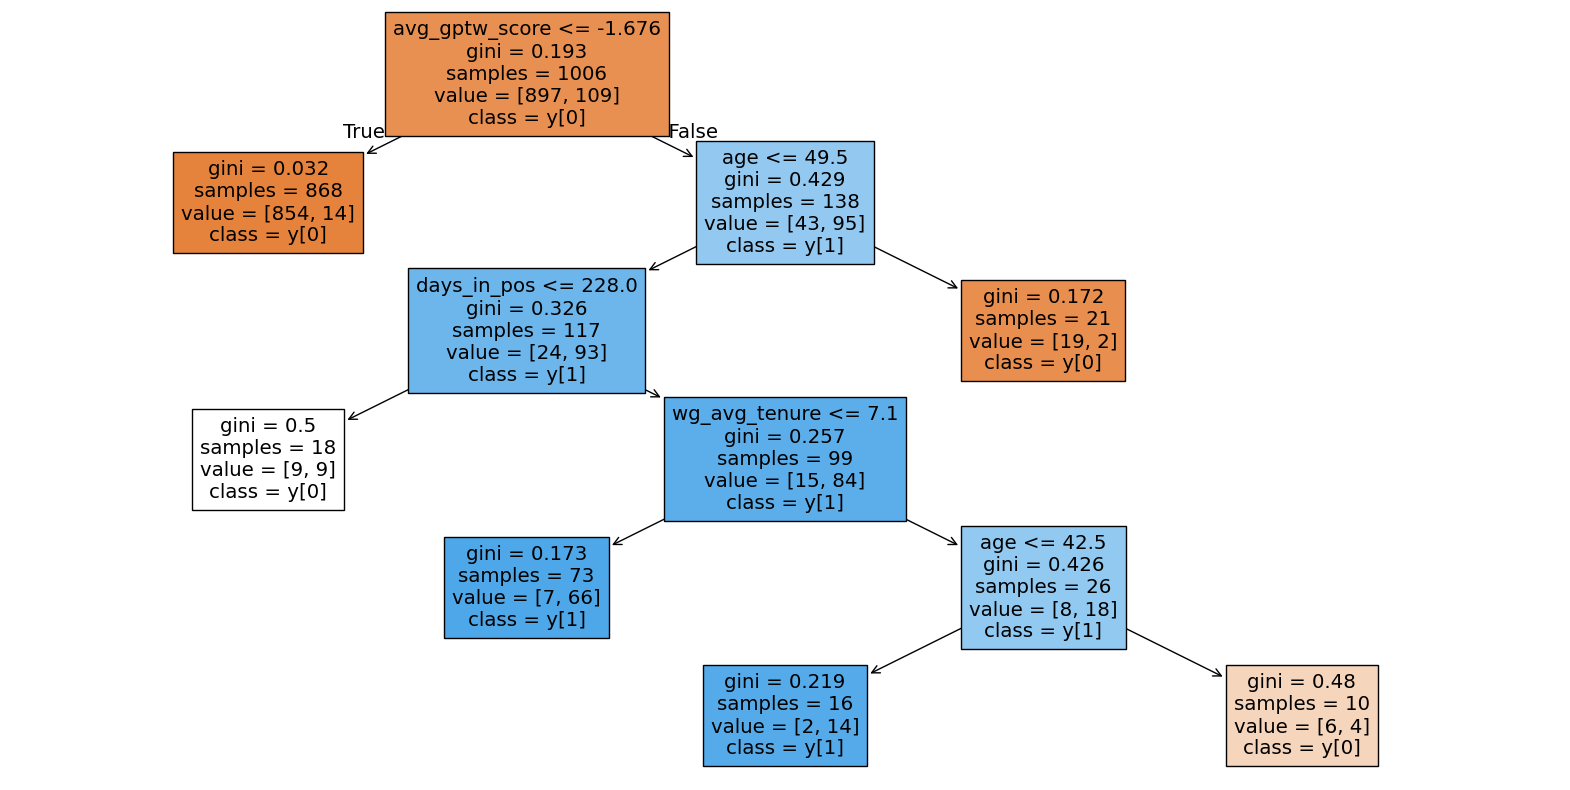

In [0]:
# Funzione per contare gli split (nodi interni)
def get_nsplit(clf):
    children_left = clf.tree_.children_left
    n_leaves = np.sum(children_left == -1)
    return clf.tree_.node_count - n_leaves

# Funzione per misurare la diversity: controlla, per ogni nodo interno
# con entrambi i figli foglia, se le classi predette sono diverse.
def parent_leaf_diversity(clf):
    tree = clf.tree_
    n_nodes = tree.node_count
    candidate_nodes = 0
    valid_nodes = 0
    for i in range(n_nodes):
        left = tree.children_left[i]
        right = tree.children_right[i]
        if left != -1 and right != -1:
            # Consideriamo solo se entrambi i figli sono foglia
            if tree.children_left[left] == -1 and tree.children_left[right] == -1:
                candidate_nodes += 1
                left_class = tree.value[left][0].argmax()
                right_class = tree.value[right][0].argmax()
                if left_class != right_class:
                    valid_nodes += 1
    return 1.0 if candidate_nodes == 0 else valid_nodes / candidate_nodes

# Funzione che calcola il best ccp_alpha e ritorna la cp_table, includendo la diversity
def optimal_xval_cp_min5split_with_diversity(X, y, 
                                             min_samples_leaf, 
                                             cv, 
                                             max_depth, 
                                             min_impurity_decrease,
                                             random_state=42):
    base_tree = DecisionTreeClassifier(random_state=random_state, 
                                       ccp_alpha=0, 
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       min_impurity_decrease=min_impurity_decrease)
    base_tree.fit(X, y)
    
    path = base_tree.cost_complexity_pruning_path(X, y)
    ccp_alphas = path.ccp_alphas
    
    rows = []
    for alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=random_state, 
                                     ccp_alpha=alpha, 
                                     min_samples_leaf=min_samples_leaf,
                                     max_depth=max_depth,
                                     min_impurity_decrease=min_impurity_decrease)
        scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        xerror = 1 - mean_score
        clf.fit(X, y)
        nsplit = get_nsplit(clf)
        diversity = parent_leaf_diversity(clf)
        rows.append({
            "CP": alpha,
            "nsplit": nsplit,
            "xerror": xerror,
            "xstd": std_score,
            "diversity": diversity
        })
    cp_table = pd.DataFrame(rows)
    
    # Applica la regola "min5split con diversity": si scelgono solo candidati con nsplit>=5.
    candidates = cp_table[cp_table["nsplit"] >= 5]
    if not candidates.empty:
        # Se esistono candidati con diversity pari a 1, scegliamo il più parsimonioso
        full_div = candidates[candidates["diversity"] == 1]
        if not full_div.empty:
            best_alpha = full_div.iloc[0]["CP"]
        else:
            # Altrimenti, scegliamo quello con la migliore combinazione di diversity e xerror
            best_candidate = candidates.sort_values(by=["diversity", "xerror"], ascending=[False, True]).iloc[0]
            best_alpha = best_candidate["CP"]
    else:
        best_alpha = cp_table.iloc[0]["CP"]
    
    return best_alpha, cp_table

# Parametri per la grid search
min_samples_leaf_candidates = [5, 10]
min_impurity_decrease_candidates = [0.0001, 0.0005, 0.0003]
cv = 4
max_depth = 6

# Liste per salvare i risultati per ogni area
df_keep_list = []
df_predict_list = []
fm_tree_list = []
fm_pred_xval_list = []
fm_cp_list = []
X_list = []
y_list = []
turnover_propensity_overall_list = []
turnover_propensity_2022_list = []

for area in areas:
    if area == 'all':
        df_keep = df_train.copy()
        df_keep_pred = df_predict.copy()
    elif area in regions:
        if area == 'semea':
            df_keep = df_train[(df_train['geographical_region'] == area) & 
                               (~df_train['country_region'].isin(areas))] \
                      .drop(columns='cmpnstn_anlys')
            df_keep_pred = df_predict[(df_predict['geo_region'] == area) & 
                                      (~df_predict['country_region'].isin(areas))] \
                           .drop(columns='cmpnstn_anlys')
        else:
            df_keep = df_train[(df_train['geographical_region'] == area) &
                               (~df_train['country_region'].isin(areas))]
            df_keep_pred = df_predict[(df_predict['geo_region'] == area) &
                                      (~df_predict['country_region'].isin(areas))]
    else:
        df_keep = df_train[df_train['country_region'] == area]
        df_keep_pred = df_predict[df_predict['country_region'] == area]

    # Calcolo metriche di turnover 
    print('AREA:', area)
    print('\n')
    n_term_2022 = len(df_keep[(df_keep['reference_year'] == 2022) &
                              (df_keep['employee_status'] == 'terminated')])
    print('n_term_2022:', n_term_2022)
    n_tot_2022 = len(df_keep[df_keep['reference_year'] == 2022])
    print('n_tot_2022:', n_tot_2022)
    n_term_overall = len(df_keep[df_keep['employee_status'] == 'terminated'])
    print('n_term_overall:', n_term_overall)
    n_tot_overall = len(df_keep)
    print('n_tot_overall:', n_tot_overall)
    turnover_propensity_overall_list.append(n_term_overall / n_tot_overall)
    print('turnover propensity overall:', n_term_overall / n_tot_overall)
    turnover_propensity_2022_list.append(n_term_2022 / n_tot_2022)
    print('turnover propensity 2022:', n_term_2022 / n_tot_2022)

    # Raggruppamento livelli rari per variabili categoriche
    factor_cols = [col for col in df_keep.select_dtypes(include='category').columns 
                   if col not in ["employee_status", "user_sys_id", "mgmt", "education", "successor"]]
    for factor in factor_cols:
        freq_min = 0.1
        if df_keep[factor].nunique() < 6:
            continue
        value_counts = df_keep[factor].value_counts(normalize=True)
        rare_levels = value_counts[value_counts < freq_min].index.tolist()
        if len(rare_levels) > 1:
            df_keep[factor] = df_keep[factor].apply(lambda x: 'other' if x in rare_levels else x)

    # Rinominare colonne
    df_keep = df_keep.rename(columns={
        'geographical_region': 'geo_region',
        'tenure_in_pos_days': 'days_in_pos',
        'global_leveling': 'global_lev',
        'position_class_num': 'pos_class_num'
    })
    df_keep = df_keep.drop(columns=['country_region', 'geo_region'], errors='ignore')
    df_keep_pred = df_keep_pred.drop(columns=['country_region', 'geo_region'], errors='ignore')
    
    # Gestione della colonna 'age'
    df_keep['age'] = df_keep['age'].fillna(pd.NA).astype('Int64')
    df_keep_pred['age'] = df_keep_pred['age'].fillna(pd.NA).astype('Int64')
    
    # Salvataggio dei dataframe
    df_keep_list.append(df_keep)
    df_predict_list.append(df_keep_pred)
    
    # Preparazione di X e y
    X = df_keep.drop(columns=['employee_status', 'user_sys_id', 'reference_year'], errors='ignore')
    y = df_keep['employee_status']
    X = pd.get_dummies(X, drop_first=True)
    X_list.append(X)
    y_list.append(y)
    
    # Grid search: selezioniamo solo le combinazioni in cui tutti gli split (quando applicabile)
    # hanno classi differenti, ossia dove parent_leaf_diversity == 1.
    best_overall_score = np.inf
    best_params = None
    valid_candidate_found = False  # Flag per verificare se troviamo almeno un candidato valido
    if len(df_keep) < 1000:
        cv = 3
    else:
        cv = 4

    for msl in min_samples_leaf_candidates:
        for mid in min_impurity_decrease_candidates:
            best_alpha, cp_table = optimal_xval_cp_min5split_with_diversity(
                X, y, 
                min_samples_leaf=msl,
                cv=cv,
                max_depth=max_depth,
                min_impurity_decrease=mid,
                random_state=42
            )
            clf = DecisionTreeClassifier(
                random_state=42,
                ccp_alpha=best_alpha,
                min_samples_leaf=msl,
                max_depth=max_depth,
                min_impurity_decrease=mid
            )
            clf.fit(X, y)
            scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
            xerror = 1 - np.mean(scores)
            diversity = parent_leaf_diversity(clf)
            # Accettiamo solo se la diversity è 1
            if diversity < 1:
                continue  # saltiamo questa combinazione
            valid_candidate_found = True
            # In questo caso la funzione obiettivo è semplicemente l'errore in CV
            objective = xerror
            if objective < best_overall_score:
                best_overall_score = objective
                best_params = {
                    'min_samples_leaf': msl,
                    'min_impurity_decrease': mid,
                    'ccp_alpha': best_alpha,
                    'xerror': xerror,
                    'diversity': diversity,
                    'cv_scores': scores,
                    'cp_table': cp_table
                }
    
    # Se nessuna combinazione soddisfa il vincolo (diversity == 1), scegliamo quella con la massima diversity
    if not valid_candidate_found:
        print(f"[{area}] Nessuna combinazione ha raggiunto diversity = 1; seleziono il candidato migliore in termini di diversity.")
        min_impurity_decrease_candidates_new = [0.001, 0.003,0.005]
        best_overall_score = np.inf
        for msl in min_samples_leaf_candidates:
            for mid in min_impurity_decrease_candidates_new:
                best_alpha, cp_table = optimal_xval_cp_min5split_with_diversity(
                    X, y, 
                    min_samples_leaf=msl,
                    cv=cv,
                    max_depth=max_depth,
                    min_impurity_decrease=mid,
                    random_state=42
                )
                clf = DecisionTreeClassifier(
                    random_state=42,
                    ccp_alpha=best_alpha,
                    min_samples_leaf=msl,
                    max_depth=max_depth,
                    min_impurity_decrease=mid
                )
                clf.fit(X, y)
                scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
                xerror = 1 - np.mean(scores)
                diversity = parent_leaf_diversity(clf)
                objective = xerror - diversity  # qui penalizziamo meno se la diversity è alta
                if objective < best_overall_score:
                    best_overall_score = objective
                    best_params = {
                        'min_samples_leaf': msl,
                        'min_impurity_decrease': mid,
                        'ccp_alpha': best_alpha,
                        'xerror': xerror,
                        'diversity': diversity,
                        'cv_scores': scores,
                        'cp_table': cp_table
                    }
    
    print(f"[{area}] Best Parameters:")
    print(best_params)
    
    # --- Costruzione del modello finale con i parametri selezionati ---
    clf_final = DecisionTreeClassifier(
        random_state=42,
        ccp_alpha=best_params['ccp_alpha'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_depth=max_depth,
        min_impurity_decrease=best_params['min_impurity_decrease']
    )
    clf_final.fit(X, y)
    
    scores_final = cross_val_score(clf_final, X, y, cv=cv, scoring='accuracy')
    fm_pred_xval_list.append(scores_final)
    fm_tree_list.append(clf_final)
    fm_cp_list.append(best_params['ccp_alpha'])

# Esempio: plot dell'albero per la prima area
plt.figure(figsize=(20,10))
plot_tree(fm_tree_list[0], feature_names=X_list[0].columns, class_names=True, filled=True)
plt.show()



=== Elaborazione per area: italy ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard              889                8
Ref_terminated            28               81
Precision (Training): 0.91, Recall (Training): 0.74
Confusion Matrix (CV):
                Pred_onboard  Pred_terminated
Ref_onboard              874               23
Ref_terminated            25               84
Precision (CV): 0.79, Recall (CV): 0.77


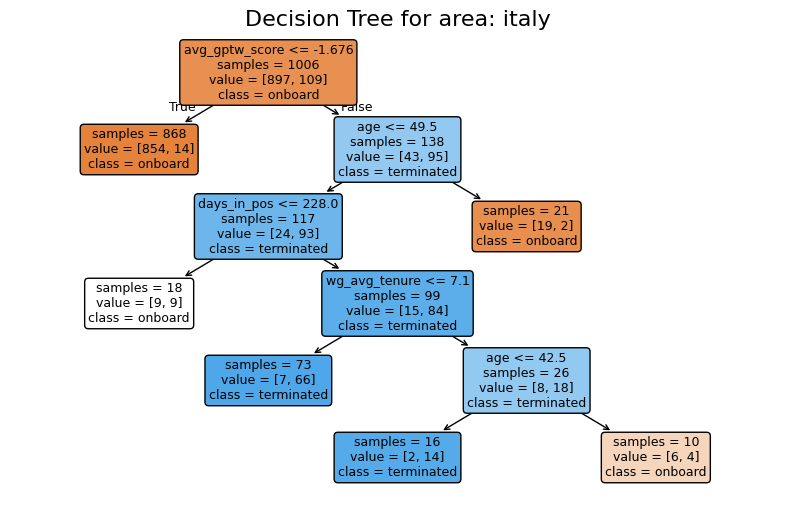


=== Elaborazione per area: jamaica ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard              362               14
Ref_terminated            13               45
Precision (Training): 0.76, Recall (Training): 0.78
Confusion Matrix (CV):
                Pred_onboard  Pred_terminated
Ref_onboard              363               13
Ref_terminated            33               25
Precision (CV): 0.66, Recall (CV): 0.43


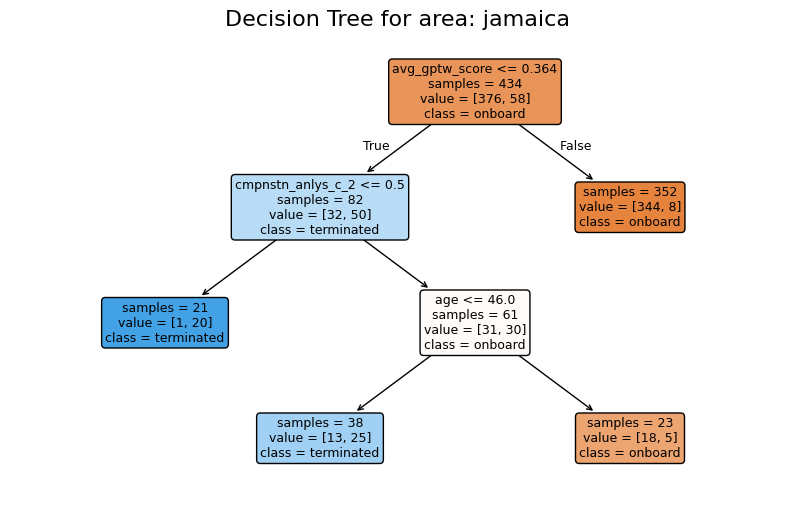


=== Elaborazione per area: semea ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard              464               11
Ref_terminated            29               40
Precision (Training): 0.78, Recall (Training): 0.58
Confusion Matrix (CV):
                Pred_onboard  Pred_terminated
Ref_onboard              448               27
Ref_terminated            32               37
Precision (CV): 0.58, Recall (CV): 0.54


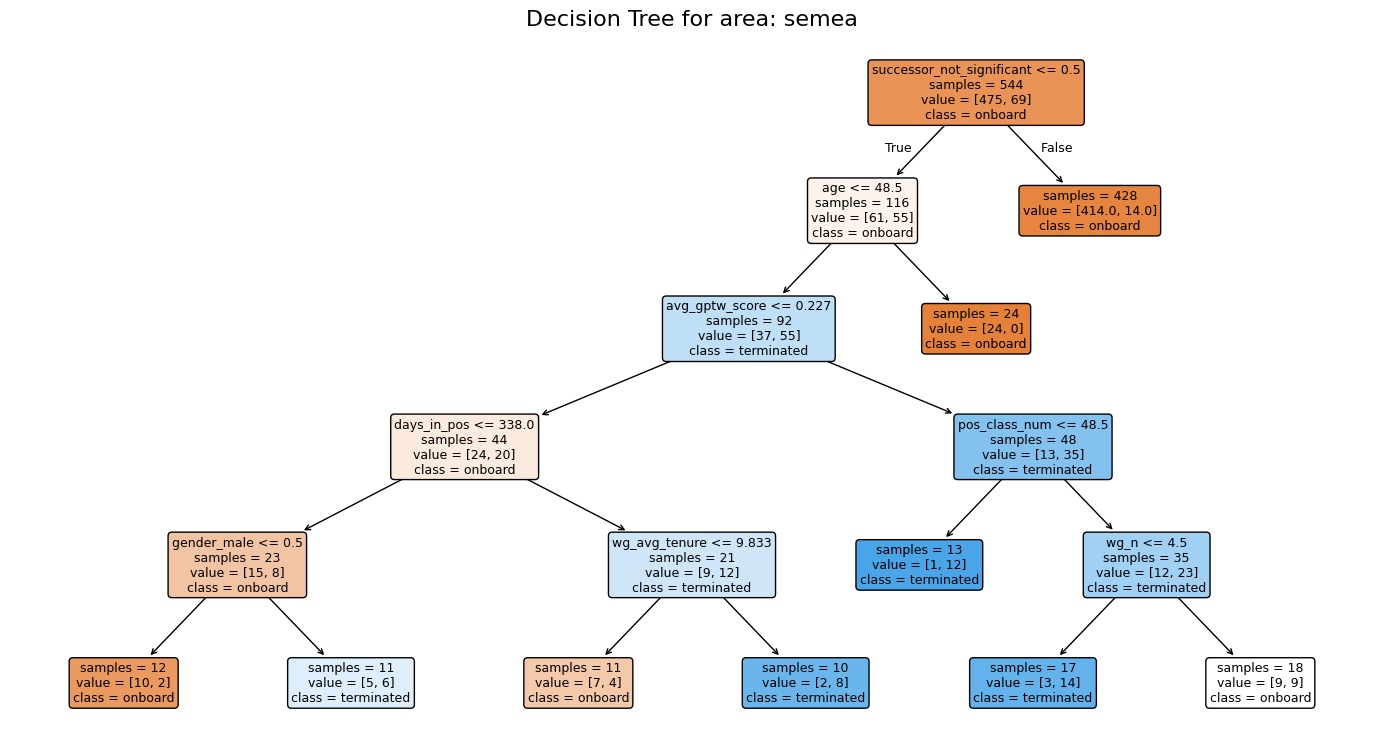


=== Elaborazione per area: apac ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard              355               29
Ref_terminated            13               80
Precision (Training): 0.73, Recall (Training): 0.86
Confusion Matrix (CV):
                Pred_onboard  Pred_terminated
Ref_onboard              342               42
Ref_terminated            35               58
Precision (CV): 0.58, Recall (CV): 0.62


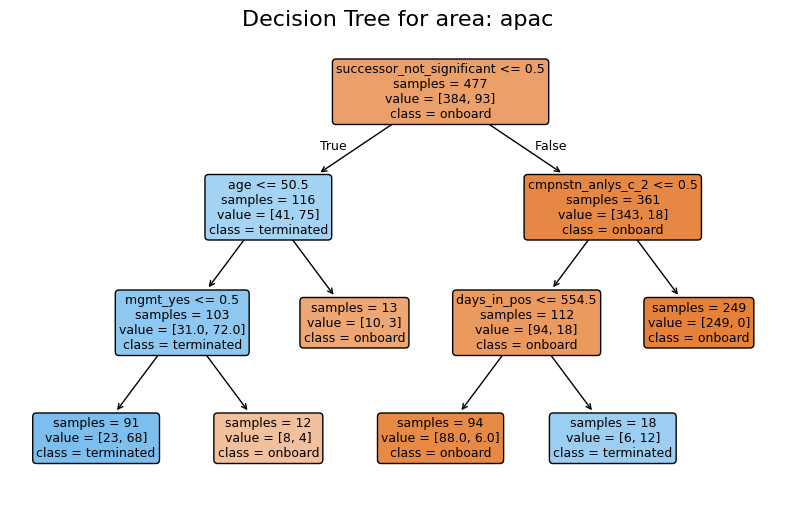


=== Elaborazione per area: ncee ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard              543                9
Ref_terminated            26               86
Precision (Training): 0.91, Recall (Training): 0.77
Confusion Matrix (CV):
                Pred_onboard  Pred_terminated
Ref_onboard              522               30
Ref_terminated            29               83
Precision (CV): 0.73, Recall (CV): 0.74


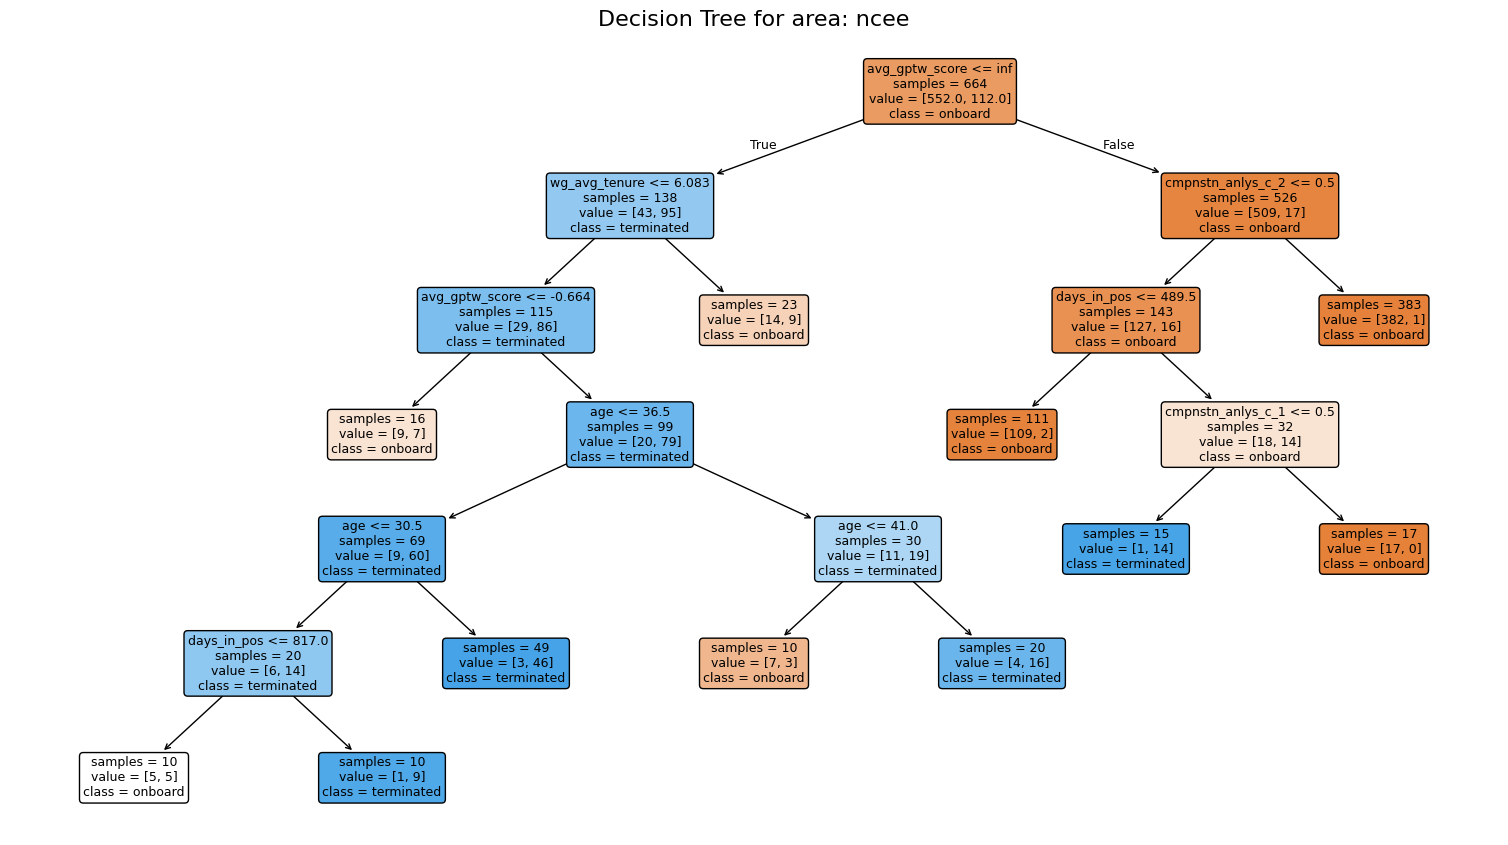


=== Elaborazione per area: americas ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard             1068               49
Ref_terminated            26              247
Precision (Training): 0.83, Recall (Training): 0.90
Confusion Matrix (CV):
                Pred_onboard  Pred_terminated
Ref_onboard             1051               66
Ref_terminated            72              201
Precision (CV): 0.75, Recall (CV): 0.74


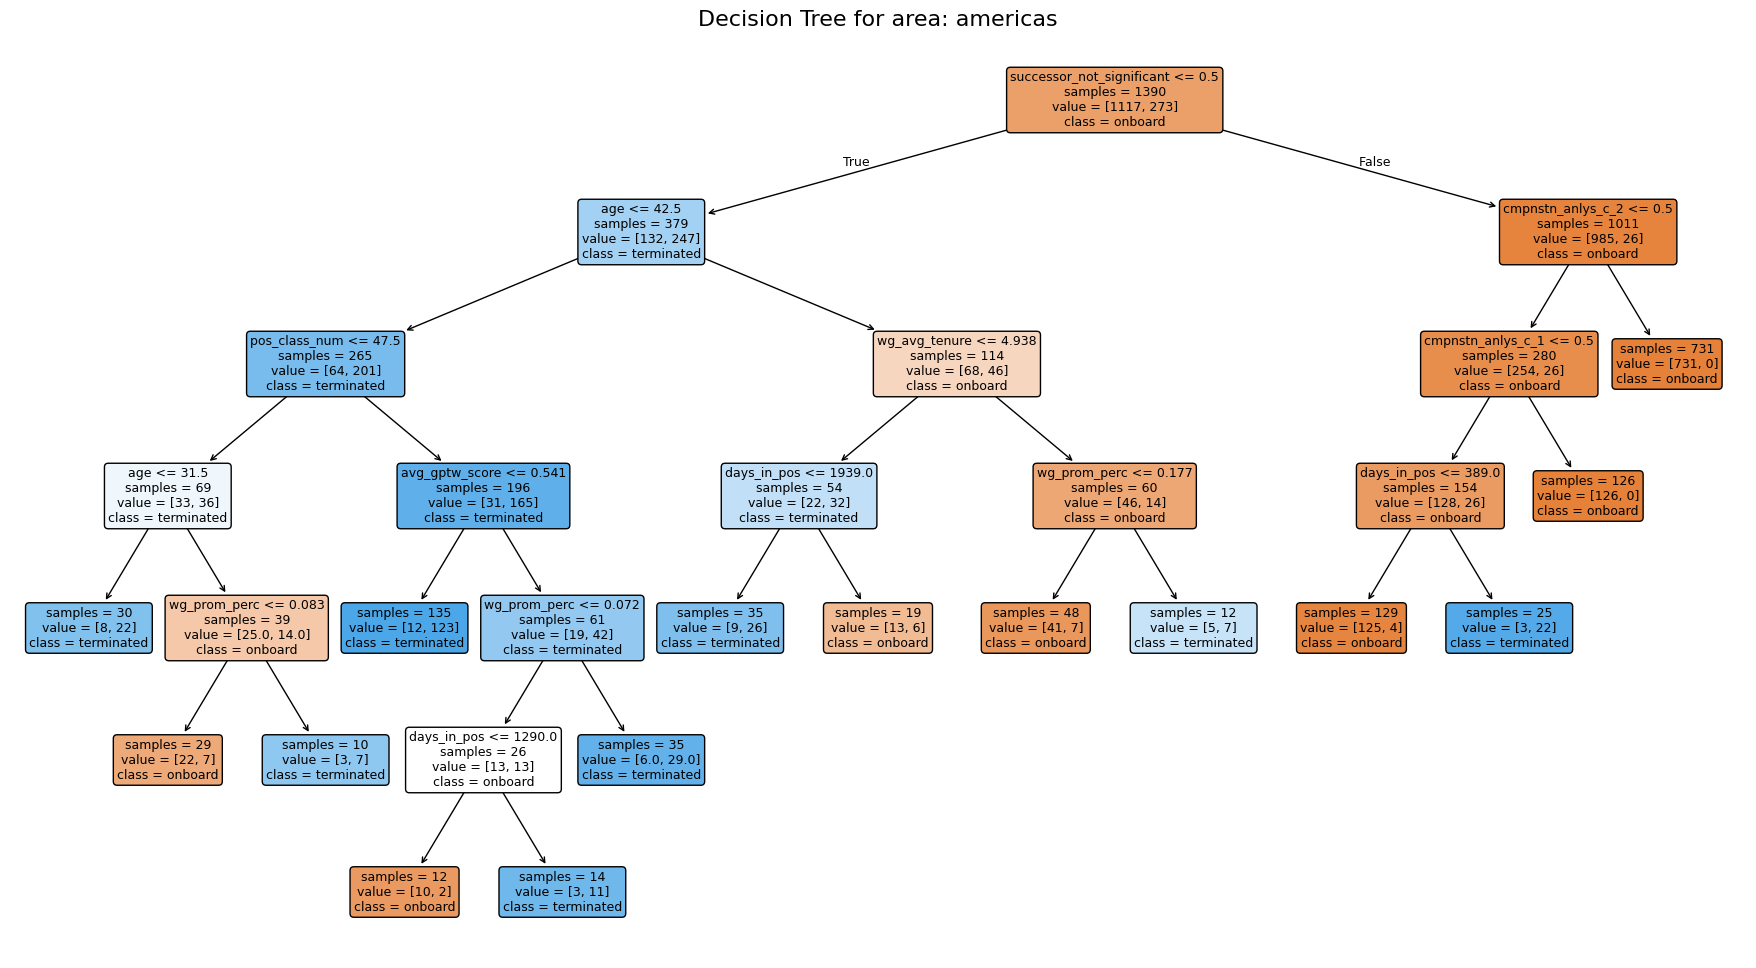


=== Elaborazione per area: all ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard             3593              208
Ref_terminated            72              642
Precision (Training): 0.76, Recall (Training): 0.90
Confusion Matrix (CV):
                Pred_onboard  Pred_terminated
Ref_onboard             3576              225
Ref_terminated           147              567
Precision (CV): 0.72, Recall (CV): 0.79


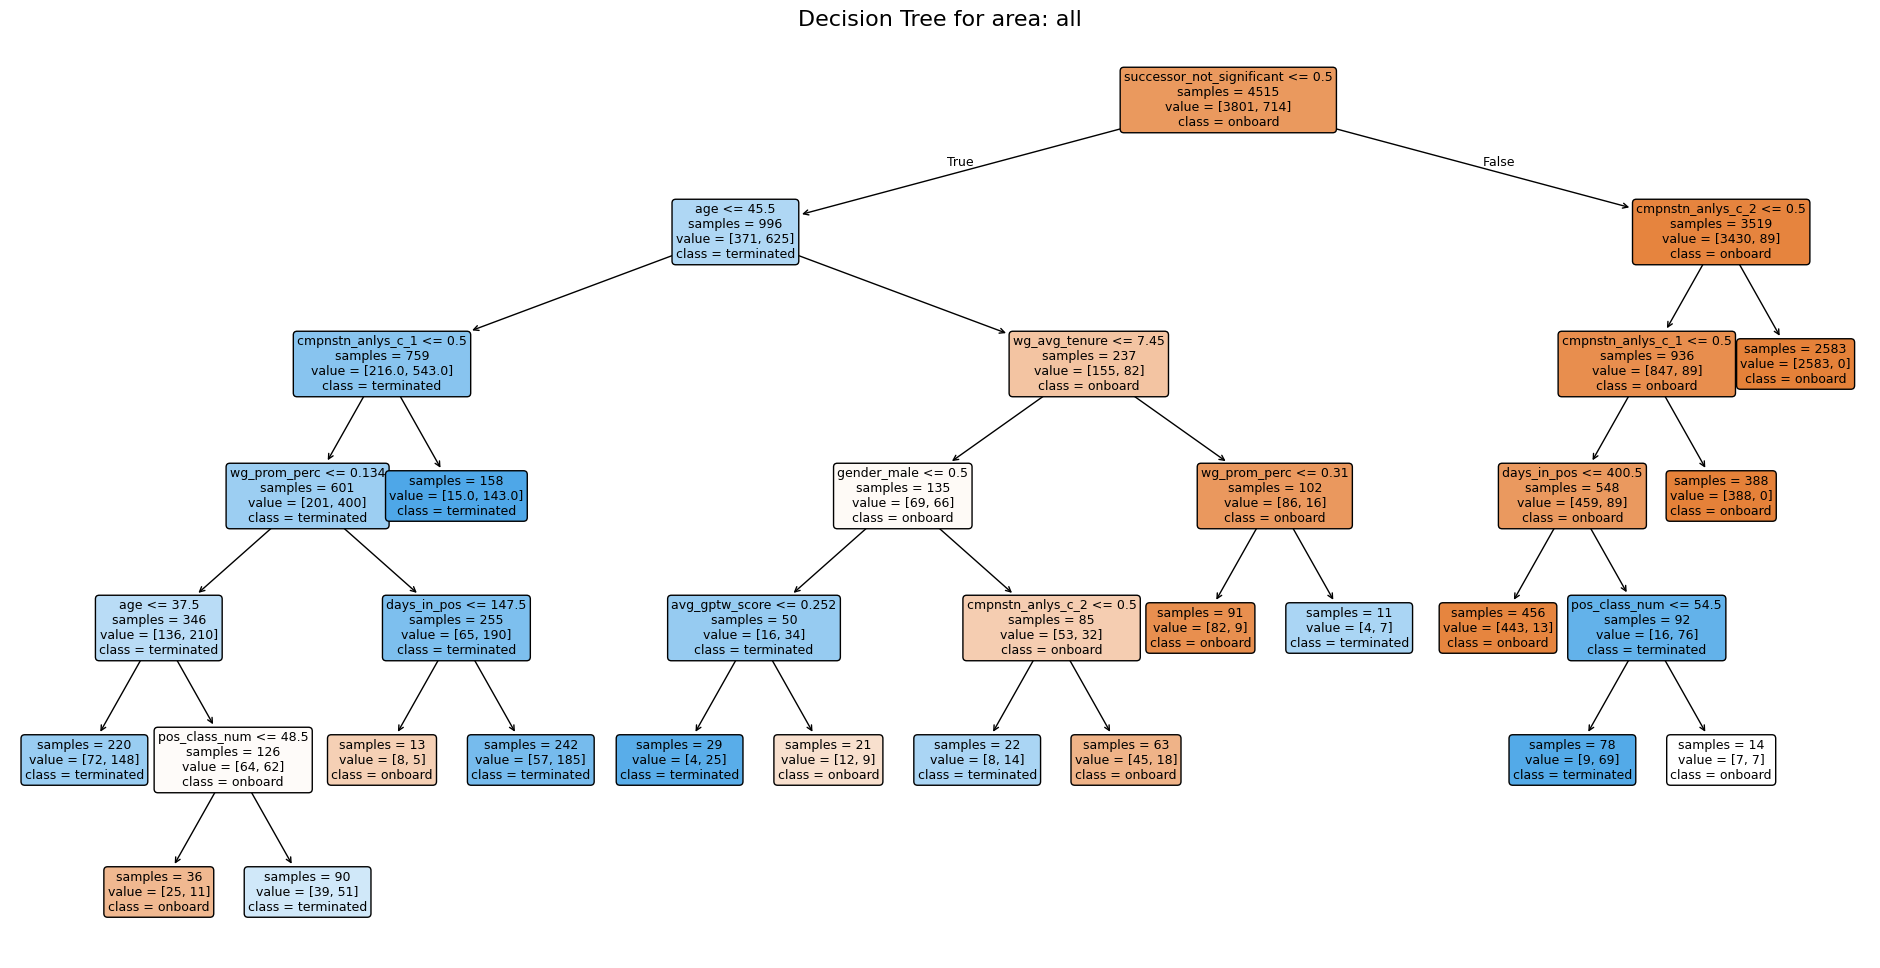

In [0]:
for i, area in enumerate(areas):
    print(f"\n=== Elaborazione per area: {area} ===")
        
    # Recupera i DataFrame per il training e per le nuove predizioni
    df_keep = df_keep_list[i]
    df_keep_pred = df_predict_list[i]

    fm = fm_tree_list[i]

    # Trova l'indice della classe "terminated" (usato per la probabilità)
    try:
        terminated_idx = list(fm.classes_).index("terminated")
    except ValueError:
        raise ValueError("La classe 'terminated' non è presente in fm.classes_.")

    # rimuove la colonna identificativa,
    # esegue get_dummies e allinea le colonne secondo X_list[i]
    X_train = df_keep.drop(columns=['user_sys_id'])
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_train = X_train.reindex(columns=X_list[i].columns, fill_value=0)

    # Predizioni sul training set
    pred = fm.predict(X_train)
    pred_prob_all = fm.predict_proba(X_train)
    pred_prob = pred_prob_all[:, terminated_idx]

    if len(df_keep) < 1000:
        cv = 3
    else:
        cv = 4
    # Cross-validation (utilizzando cross_val_predict)
    xval_pred = cross_val_predict(fm, X_train, df_keep['employee_status'], cv=cv)

    # Creazione del DataFrame di predizione sul training set
    df_pred = df_keep.copy()
    df_pred['pred'] = pred
    df_pred['pred_prob'] = pred_prob
    epsilon = 1e-6  # Evita divisioni per numeri troppo piccoli
    df_pred['leverage'] = np.round(pred_prob / np.maximum(turnover_propensity_overall_list[i], epsilon), 4) 

    # Calcolo delle metriche (confusion matrix, precision e recall)
    cm = confusion_matrix(df_keep['employee_status'], pred, labels=["onboard", "terminated"])
    precision_val = precision_score(df_keep['employee_status'], pred, pos_label="terminated")
    recall_val = recall_score(df_keep['employee_status'], pred, pos_label="terminated")
    cm_df = pd.DataFrame(cm, 
                            index=['reference_onboard', 'reference_terminated'], 
                            columns=['predicted_onboard', 'predicted_terminated'])
    conf_matrix_html = cm_df.to_html(index=True)

    xval_cm = confusion_matrix(df_keep['employee_status'], xval_pred, labels=["onboard", "terminated"])
    xval_precision = precision_score(df_keep['employee_status'], xval_pred, pos_label="terminated")
    xval_recall = recall_score(df_keep['employee_status'], xval_pred, pos_label="terminated")

    print("Confusion Matrix (Training):")
    print(pd.DataFrame(cm, index=["Ref_onboard", "Ref_terminated"],
                        columns=["Pred_onboard", "Pred_terminated"]))
    print(f"Precision (Training): {precision_val:.2f}, Recall (Training): {recall_val:.2f}")
    print("Confusion Matrix (CV):")
    print(pd.DataFrame(xval_cm, index=["Ref_onboard", "Ref_terminated"],
                        columns=["Pred_onboard", "Pred_terminated"]))
    print(f"Precision (CV): {xval_precision:.2f}, Recall (CV): {xval_recall:.2f}")
    # Visualizza l'albero 
    # Numero di nodi nell'albero
    num_nodes = fm.tree_.node_count  

    # Dimensione adattativa per immagini piccole e grandi
    if num_nodes <= 13:
        fig_width, fig_height = 10, 6  # Compatto e leggibile
        fontsize = 9  # Più grande per pochi nodi
    else:
        fig_width = min(16 + (num_nodes - 13) * 0.4, 30)  # Cresce ma limitata
        fig_height = min(8 + (num_nodes - 13) * 0.3, 12)  # Altezza moderata
        fontsize = 9  # Fontsize resta leggibile

    plt.figure(figsize=(fig_width, fig_height))
    plot_tree(
        fm,
        feature_names=list(X_list[i].columns),
        class_names=list(fm.classes_),
        filled=True,
        impurity=False,
        proportion=False,
        fontsize=fontsize,
        rounded=True
    )
    plt.title(f"Decision Tree for area: {area}", fontsize=16)
    plt.show()

Generazione report html per areas:

In [0]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import base64
from io import BytesIO

css_content = """
<style>
/* Reset base styles */
* {
    margin: 0;
    padding: 0;
    box-sizing: border-box;
}

/* Corpo della pagina */
body {
    font-family: Arial, sans-serif;
    background-color: #f4f4f4;
    color: #333;
    line-height: 1.6;
}

/* Fascia iniziale (intro) – estesa a tutta larghezza, non in cella */
.intro-section {
    background-color: #004b87; /* Blu scuro */
    color: white; /* Testo bianco */
    text-align: center;
    padding: 40px 20px;
    width: 100%;
}

.intro-section h2 {
    font-size: 2.5rem; /* Titolo leggermente ridotto */
    color: white;
    margin-bottom: 10px;
    text-align: center;
}

.intro-section p {
    font-size: 1.2rem;
    line-height: 1.8;
    margin-bottom: 20px;
    text-align: center;
    padding: 0 10px;
}

/* Sezione Indice – sfondo bianco, testo blu, link blu */
.index-section {
    background-color: #fff;  /* Sfondo bianco */
    color: #004b87;         /* Testo blu */
    padding: 30px 20px;
    border-radius: 8px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
    text-align: left;
}

.index-section h3 {
    color: #004b87;
    font-size: 1.8rem;
    margin-bottom: 15px;
    text-align: left;
}

.index-section ul {
    list-style-type: disc;
    padding-left: 25px;
}

.index-section ul ul {
    list-style-type: circle;
    padding-left: 20px;
}

.index-section li {
    margin: 6px 0;
}

/* Link nell'indice: colore blu sempre, anche al passaggio del mouse */
.index-section a {
    color: #004b87;
    text-decoration: none;
    font-weight: bold;
    display: inline-block;
}
.index-section a:hover {
    text-decoration: none;
    color: #004b87;
}

/* Celle delle altre sezioni – rimangono invariati */
.section-container {
    padding: 20px;
    margin: 20px 0;
    background-color: #fff;
    border-radius: 8px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
}

.analysis-section {
    padding: 20px;
    margin: 20px 0;
    background-color: #fff;
    border-radius: 8px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
}

h5 {
    font-size: 1.2rem;
    margin-top: 15px;
}
h4 {
    font-size: 1.3rem;
    margin-top: 15px;
}

h3 {
    font-size: 1.5rem;
    margin-top: 15px;
}

/* Titoli generali */
h2 {
    font-size: 1.7rem;
    color: #004b87;
    margin-bottom: 10px;
}

ul {
    list-style-type: disc;
    padding-left: 20px;
}

/* Footer */
footer {
    background-color: #004b87;
    color: white;
    text-align: center;
    padding: 10px;
    margin-top: 40px;
}

footer p {
    font-size: 1rem;
}

/* Altri stili */
#main .nav-pills > li.active > a,
#main .nav-pills > li.active > a:hover,
#main .nav-pills > li.active > a:focus {
    background-color: #224d98;
}
#main .nav-pills > li > a:hover {
    background-color: #224d98;
}

h1, h2, h3, h4, h5, h6, legend {
    color: #224d98;
    text-align: left;
}

#nav-top span.glyphicon {
    color: #224d98;
}

#table-of-contents header {
    color: #224d98;
}

#main a {
    background-image: linear-gradient(180deg, #224d98, #224d98);
    color: #224d98;
}
a:hover {
    color: #224d98;
}
a:visited {
    color: #224d98;
}

#postamble {
    background: #224d98;
    border-top: solid 10px #224d98;
}

#sidebar {
    background: #224d98;
}
#sidebar h2 {
    background-color: #224d98;
}

/* Struttura generale */
.container {
    width: 100%;
    margin: 0 auto;
    padding: 0 10px;
    text-align: left;
}

.image-container-adaptive img {
    max-width: 98%;
    height: auto;
    display: block;
    margin: 0 auto;
}

.image-container-small img {
    max-width: 60%;
    height: auto;
    display: block;
    margin: 0 auto;
}

table {
    border-collapse: collapse;
    width: auto;
    margin: 10px 0;
}
table, th, td {
    border: 1px solid black;
}
th, td {
    padding: 8px;
    text-align: center;
}
th {
    background-color: #f2f2f2;
}
.table-container {
    text-align: left;
    max-width: 60%;
    margin: 0;
}

/* Specifiche per la sezione */
section {
    padding: 20px;
    margin: 20px 0;
    background-color: #fff;
    border-radius: 8px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
}
h2 {
    font-size: 1.7rem;
    color: #004b87;
    margin-bottom: 10px;
}
h5 {
    font-size: 1.2rem;
    margin-top: 15px;
}
h4 {
    font-size: 1.3rem;
    margin-top: 15px;
}
h3 {
    font-size: 1.5rem;
    margin-top: 15px;
}
ul {
    list-style-type: disc;
    padding-left: 20px;
}
</style>

"""

html_content = f"""
<html>
<head>
    {css_content}
</head>
<body>
<div class="container">
    <div class="right-panel">
        <!-- Prima sezione con background blu e testo bianco -->
        <section class="intro-section">
            <h2>Campari Employee Turnover</h2>
            <p>Employee turnover is a figure on which every company’s HR attention is focused, especially in recent years.
            Indeed, the cost of employee turnover affects the organization’s operational capabilities and budget.
            Employee turnover is both costly and disruptive to organizational functions; turnover costs involve recruitment, selection, and training.
            The employee turnover of interest in this study is voluntary resignation, as in some cases it can be prevented by mitigating actions.</p>
        </section>

        <section class="index-section">
            <h3>Index</h3>
            <ul>
                <li><a href="#project-goal">1. Project Goal</a></li>
                <li>
                    <a href="#data">2. Data</a></li>
                    <ul>
                        <li><a href="#scope">2.1 Scope of the Analysis</a></li>
                        <li><a href="#variables">2.2 Variables</a></li>
                        <li><a href="#gptw">2.2.1 GPTW</a></li>
                        <li><a href="#survey">2.2.1.1 Survey Scores</a></li>
                        <li><a href="#variable-selection">2.2.1.2 GPTW Variable Selection</a></li>
                        <li><a href="#model-variables">2.2.2 Variables considered by the model</a></li>
                    </ul>
                </li>
                <li><a href="#methodology">3. Methodology</a></li>
                <li>
                    <a href="#analysis">4. Analysis</a></li>
                    <ul>
                         <li><a href="#area1">4.1 Italy</a></li>
                        <li><a href="#area2">4.2 Jamaica</a></li>
                        <li><a href="#area3">4.3 Semea</a></li>
                        <li><a href="#area4">4.4 Apac</a></li>
                        <li><a href="#area5">4.5 Ncee</a></li>
                        <li><a href="#area6">4.6 Americas</a></li>
                        <li><a href="#area3">4.7 All</a></li>
                    </ul>
                </li>
            </ul>
        </section>
                
        <!-- Altre sezioni vanno qui... -->
        <section id="project-goal" class="section-container">
            <h3>1. Project Goal</h3>
            <ul>
                <li>Define personas with high turnover propensity.</li>
                <li>Calculate the turnover propensity for all the employees.</li>
                <li>Build mitigation scenarios for the employees with high turnover propensity, and calculate the turnover propensity mitigated by each action.</li>
                <li>Identify the best mitigating action for each employee.</li>
            </ul>
        </section>
        
        <section id="data" class="section-container">
            <h3>2. Data</h3>
            <p>Data is provided as a snapshot of the situation at the end of the year.<br>Data is available for the following years: 2018, 2019, 2020, 2021, 2022.</p>
        </section>
        
        <section id="scope-analysis" class="section-container">
            <h4>2.1 Scope of the Analysis</h4>
            <p>In order to narrow the analysis, the following scope of analysis is considered.<br> The blue collars are removed from the analysis, as their turnover has different dynamics.<br> A subsequent ad hoc analysis may possibly be considered for this category of employees.<br> Senior Executive and Officer level employees are also removed from the analysis as they represent a very small part of the population and are subjected to different dynamics.<br> Only employees with permanent contracts are retained.<br> Expat employees are excluded.<br></p> 
            <p>There are {n_tot_overall} employees in the scope of analysis.</p>
        </section>
        
        <section id="variables" class="section-container">
            <h4>2.2 Variables</h4>
            <p>Four categories of data are available:</p>
            <ul>
                <li>Biographical data (age, gender, etc.)</li>
                <li>Employment status (position, level, etc.)</li>
                <li>Changes derived from historical data (years since last promotion, etc.)</li>
                <li>Great Place to Work (GPTW) survey results.</li>
            </ul>
        </section>

        <section id="gptw" class="section-container">
            <h5>2.2.1 GPTW</h5>
            <h5 id="survey">2.2.1.1 Survey scores</h5>
            <p>GPTW surveys are held every two years. Therefore, survey results are only available for the years 2016, 2018, 2020, and 2022. The questionnaires are held at the end of the year, therefore it is assumed that the result of each survey can influence the following two years. Therefore, the 2016 survey is associated with the 2018 data, the 2018 survey with the 2019 and 2020 data, the 2020 survey with the 2021 and 2022 data, and the 2022 survey with the 2023 data.</p>

            <p>The surveys have multiple questions, which are grouped by macro areas (credibility, respect, fairness, pride, camaraderie), for which the average score is reported.</p>

            The scores resulting from the surveys are the result of averaging by employee grouping based on a certain criterion.<br>
            As for 2016, 2018 and 2020, the grouping is based on the intersection of the variables country and function.<br>
            It also happens that for some countries data for a specific function is not available. In that case, the average score of the whole country is used. The results of the 2022 survey are available at a higher level of detail, but to keep the data consistent, the same level of detail is equally used as in previous surveys.</p>
        </section>
        <section id="gptw-selection" class="section-container">
            <h5>2.2.1.2 GPTW variable selection</h5>
            <p>GPTW scores are highly correlated with each other: it is rare to find clusters where there is a strong difference between the scores recorded for a specific macro area and the others. For this reason, we use a statistical technique to reduce dimensionality and construct new variables that summarize the original variability of the 5 macro areas. The data are also standardized: thus, a score close to 0 indicates values close to the mean, while a value of -1 (+1) indicates a value lower (higher) than the mean by one standard deviation.</p>

            <p>Through this statistical technique, called main component analysis, new variables, constructed as a linear combination of the others, are obtained.<br>
            The first variable thus obtained explains nearly 90 percent of the total variability and represents an average of the scores of the five macro areas.<br>
            For this reason, it is decided to include the average of the standardized responses in the 5 macro areas as a summary of the information contained in the GPTW surveys.</p>
        </section>
        <section id="model-variables" class="section-container">
            <h5>2.2.2.2 Variables considered by the model</h5>
            <p>The variables available for analysis are as follows:</p>
            {html_list}
            {row_count_string}
        </section>
        <section id="methodology" class="section-container">
            <h3>3 Methodology</h3>
            <ul>
                <li>Breakdown of data by geographic area to treat them independently</li>
                <li>Binomial decision tree model with response variable <strong>LEAVER</strong></li>
                <li>Choice of tree depth based on <em>leave-one-out cross-validation</em></li>
                <li>Segmentation of employees into clusters based on tree results</li>
                <li>Confusion Matrix, precision, and recall relative to tree performance</li>
                <li>Calculation of leverage relative to each employee in the current state</li>
                <li>Risk mitigation scenarios with relative effect on each employee’s leverage</li>
            </ul>
        </section>
        <section id="analysis" class="section-container">
            <h3>4 Analysis</h3>
            <p>The analysis was conducted separately for each geographic macroarea, and for the countries Italy and Jamaica.<br>
            For all categorical variables, only classes with a frequency greater than 10% are considered.
            The remaining classes are merged.<br>
            To calculate turnover propensity, a tree regression model was constructed using Turnover as the response variable, and demographic and behavioral variables as regressors.<br>
            The explanatory power of the model is summarized by the confusion matrix and the measures of precision and recall.<br>
            The leverage of each employee is calculated as the ratio of the dropout rate in the leaf to which he or she belongs to the overall dropout rate.<br>
            On each high-risk employee, HR can perform the following risk mitigation actions:</p>
            <ul>
                <li>position change</li>
                <li>salary review</li>
                <li>increase working group dimension</li>
                <li>manager change</li>
                <li>assignment of a successor</li>
                <li>promotion</li>
            </ul>
            <p>Leverage for each employee is calculated by applying each of the possible scenarios.
            Please note that if a variable is not selected from the tree any mitigation action performed on that variable will be considered irrelevant by the model.</p>
        </section>
    </div>
</html>
"""

df_emp_keep = pd.DataFrame()  

for i, area in enumerate(areas):
    print(f"\n=== Elaborazione per area: {area} ===")
        
    # Recupera i DataFrame per il training e per le nuove predizioni
    df_keep = df_keep_list[i]
    df_keep_pred = df_predict_list[i]

    fm = fm_tree_list[i]

    # Trova l'indice della classe "terminated" (usato per la probabilità)
    try:
        terminated_idx = list(fm.classes_).index("terminated")
    except ValueError:
        raise ValueError("La classe 'terminated' non è presente in fm.classes_.")

    # rimuove la colonna identificativa,
    # esegue get_dummies e allinea le colonne secondo X_list[i]
    X_train = df_keep.drop(columns=['user_sys_id'])
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_train = X_train.reindex(columns=X_list[i].columns, fill_value=0)

    # Predizioni sul training set
    pred = fm.predict(X_train)
    pred_prob_all = fm.predict_proba(X_train)
    pred_prob = pred_prob_all[:, terminated_idx]
    if len(df_keep) < 1000:
        cv = 3
    else:
        cv = 4

    # Cross-validation 
    xval_pred = cross_val_predict(fm, X_train, df_keep['employee_status'], cv=cv)

    # Creazione del DataFrame di predizione sul training set
    df_pred = df_keep.copy()
    df_pred['pred'] = pred
    df_pred['pred_prob'] = pred_prob
    epsilon = 1e-6  # Evita divisioni per numeri troppo piccoli
    df_pred['leverage'] = np.round(pred_prob / np.maximum(turnover_propensity_overall_list[i], epsilon), 4) 

    # Calcolo delle metriche (confusion matrix, precision e recall)
    cm = confusion_matrix(df_keep['employee_status'], pred, labels=["onboard", "terminated"])
    precision_val = precision_score(df_keep['employee_status'], pred, pos_label="terminated")
    recall_val = recall_score(df_keep['employee_status'], pred, pos_label="terminated")
    cm_df = pd.DataFrame(cm, 
                            index=['reference_onboard', 'reference_terminated'], 
                            columns=['predicted_onboard', 'predicted_terminated'])
    conf_matrix_html = cm_df.to_html(index=True)

    xval_cm = confusion_matrix(df_keep['employee_status'], xval_pred, labels=["onboard", "terminated"])
    xval_precision = precision_score(df_keep['employee_status'], xval_pred, pos_label="terminated")
    xval_recall = recall_score(df_keep['employee_status'], xval_pred, pos_label="terminated")

    print("Confusion Matrix (Training):")
    print(pd.DataFrame(cm, index=["Ref_onboard", "Ref_terminated"],
                        columns=["Pred_onboard", "Pred_terminated"]))
    print(f"Precision (Training): {precision_val:.2f}, Recall (Training): {recall_val:.2f}")
    print("Confusion Matrix (CV):")
    print(pd.DataFrame(xval_cm, index=["Ref_onboard", "Ref_terminated"],
                        columns=["Pred_onboard", "Pred_terminated"]))
    print(f"Precision (CV): {xval_precision:.2f}, Recall (CV): {xval_recall:.2f}")
    # Visualizza l'albero 
    # Numero di nodi nell'albero
    num_nodes = fm.tree_.node_count  

    # Dimensione adattativa per immagini piccole e grandi
    if num_nodes <= 13:
        fig_width, fig_height = 10, 6  # Compatto e leggibile
        fontsize = 9  # Più grande per pochi nodi
    else:
        fig_width = min(16 + (num_nodes - 13) * 0.4, 30)  # Cresce ma limitata
        fig_height = min(8 + (num_nodes - 13) * 0.3, 12)  # Altezza moderata
        fontsize = 9  # Fontsize resta leggibile

    plt.figure(figsize=(fig_width, fig_height))
    plot_tree(
        fm,
        feature_names=list(X_list[i].columns),
        class_names=list(fm.classes_),
        filled=True,
        impurity=False,
        proportion=False,
        fontsize=fontsize,
        rounded=True
    )
    plt.title(f"Decision Tree for area: {area}", fontsize=16)
    # Aggiungi una legenda personalizzata
    legend_text = (
        r"$\mathbf{Legend:}$" "\n" +
        r"$\mathit{Samples}$: number of examples in the node" "\n" +
        r"$\mathit{Values}$: class distribution in the node" "\n" +
        r"$\mathit{Left branch}$: condition satisfied" "\n" +
        r"$\mathit{Right branch}$: condition not satisfied"
    )
    # Posiziona il testo in basso a sinistra
    plt.gcf().text(0.02, 0.98, legend_text, fontsize=fontsize,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    # Migliora la spaziatura
    plt.tight_layout()

    # Salva l'immagine
    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png', bbox_inches='tight', dpi=120)
    plt.close()
    img_buffer.seek(0)
    tree_img_base64 = base64.b64encode(img_buffer.read()).decode('utf-8')
    plt.show()
    # Definisce la classe CSS da applicare
    image_class = "image-container-small" if num_nodes <= 13 else "image-container-adaptive"

    # Mappatura dei nodi foglia per il training set
    employee_leaf = df_keep[['user_sys_id']].copy()
    employee_leaf['leaf'] = fm.apply(X_train)
    unique_leaves = np.sort(employee_leaf['leaf'].unique())
    leaf_map = {leaf: idx+1 for idx, leaf in enumerate(unique_leaves)}
    employee_leaf['personas'] = employee_leaf['leaf'].map(leaf_map)
    employee_leaf.drop(columns=['leaf'], inplace=True)
    
    # SEZIONE: EVENTUALI INFO AGGIUNTIVE (anag_cmpnstn_anlys)
    if area != 'semea':
        anag_focus = anag_cmpnstn_anlys[anag_cmpnstn_anlys['cmpnstn_anlys'].isin(df_keep['cmpnstn_anlys'].unique())]
        anag_focus = anag_focus.sort_values(by='cmpnstn_anlys', ascending=False)
        anag_focus_html = anag_focus.to_html(index=False)

    html_content += f"""
        <div class="container">
          <section id="area{i+1}" class="analysis-section">
              <h3>4.{i+1} {area}</h3>
              <p> Number of employees in scope: {len(df_keep)}</p>
              <p> Last year’s overall turnover propensity is {turnover_propensity_2022_list[i]:.1%}</p>
              <h4>Decision tree</h4>
              <p>For each node the tree indicates:</p>
              <ul>
                <li>the most frequent class</li>
                <li>the number of observations in the most frequent class</li>
                <li>the total number of observations in the node</li>
                <li>the percentage of users in the node compared to the total population</li>
              </ul>
              <div class="{image_class}">
                  <img src="data:image/png;base64,{tree_img_base64}" alt="Albero Decisionale">
              </div>
              
              <h4>Confusion Matrix on the entire dataset</h4>
              {conf_matrix_html}
              <p>The following metrics are provided as summary measures of descriptive goodness of the model:</p>
                <p><strong>Precision</strong>: percentage of leavers among those classified as such by the model.</p>
                <p><strong>Recall</strong>:  percentage of leavers intercepted by the model out of total leavers.</p>
                <p>Precision:{precision_val:.1%}</p>
                <p>Recall:{recall_val:.1%}</p>
                <p><em>Compensation Analysis</em> is renamed as cmpnstn_anlys and the categories within it had to be recoded for graphical reasons.</p>

                <p>The values corresponding to the abbreviations displayed in the tree are given. below.</p>
                {anag_focus_html}

          </section>
      </div>
  </div>
  </body>
    """

    def create_scenario(df, modifications, scenario_name):
        df_temp = df.copy()
        for col, val in modifications.items():
            # Assegna direttamente il valore (che può essere numerico, stringa o booleano)
            df_temp[col] = val
        df_temp['scenario'] = scenario_name
        return df_temp

    #df_keep_pred['days_in_pos'] = df_keep_pred['days_in_pos'].fillna(pd.NA).astype('Int64')

    # Creazione degli scenari di mitigazione (20 scenari)
    scenarios_list = []
    scenarios_list.append(create_scenario(df_keep_pred, {'days_in_pos': 0}, 'position_change'))
    scenarios_list.append(create_scenario(df_keep_pred, {'wg_n': df_keep_pred['wg_n'] + 1}, 'bigger_wg'))
    scenarios_list.append(create_scenario(df_keep_pred, {'manager_change': 'yes'}, 'manager_change'))
    scenarios_list.append(create_scenario(df_keep_pred, {'successor': 'yes'}, 'successor'))
    scenarios_list.append(create_scenario(df_keep_pred, {'years_since_prom': 0}, 'promoted'))
    scenarios_list.append(create_scenario(df_keep_pred, {'comp_adj': True}, 'compensation_adjustment'))
    scenarios_list.append(create_scenario(df_keep_pred, {'days_in_pos': 0, 'wg_n': df_keep_pred['wg_n'] + 1}, 'position_change_and_bigger_wg'))
    scenarios_list.append(create_scenario(df_keep_pred, {'days_in_pos': 0, 'manager_change': 'yes'}, 'position_change_manager_change'))
    scenarios_list.append(create_scenario(df_keep_pred, {'days_in_pos': 0, 'successor': 'yes'}, 'position_change_successor'))
    scenarios_list.append(create_scenario(df_keep_pred, {'days_in_pos': 0, 'years_since_prom': 0}, 'position_change_promoted'))
    scenarios_list.append(create_scenario(df_keep_pred, {'days_in_pos': 0, 'comp_adj': True}, 'position_change_comp_adj'))
    scenarios_list.append(create_scenario(df_keep_pred, {'wg_n': df_keep_pred['wg_n'] + 1, 'manager_change': 'yes'}, 'bigger_wg_manager_change'))
    scenarios_list.append(create_scenario(df_keep_pred, {'wg_n': df_keep_pred['wg_n'] + 1, 'successor': 'yes'}, 'bigger_wg_successor'))
    scenarios_list.append(create_scenario(df_keep_pred, {'wg_n': df_keep_pred['wg_n'] + 1, 'years_since_prom': 0}, 'bigger_wg_promoted'))
    scenarios_list.append(create_scenario(df_keep_pred, {'wg_n': df_keep_pred['wg_n'] + 1, 'comp_adj': True}, 'bigger_wg_comp_adj'))
    scenarios_list.append(create_scenario(df_keep_pred, {'manager_change': 'yes', 'successor': 'yes'}, 'manager_change_successor'))
    scenarios_list.append(create_scenario(df_keep_pred, {'manager_change': 'yes', 'years_since_prom': 0}, 'manager_change_promoted'))
    scenarios_list.append(create_scenario(df_keep_pred, {'manager_change': 'yes', 'comp_adj': True}, 'manager_change_comp_adj'))
    scenarios_list.append(create_scenario(df_keep_pred, {'successor': 'yes', 'years_since_prom': 0}, 'successor_promoted'))
    scenarios_list.append(create_scenario(df_keep_pred, {'successor': 'yes', 'comp_adj': True}, 'successor_comp_adj'))

    scenarios = pd.concat(scenarios_list, ignore_index=True)

    X_scenarios = scenarios.drop(columns=['user_sys_id'])
    # X_scenarios_dummies = pd.get_dummies(X_scenarios, drop_first=True)

    # Calcola le predizioni per gli scenari
    # pred_prob_all_sc = fm.predict_proba(X_scenarios_dummies)
    X_scenarios = pd.get_dummies(X_scenarios, drop_first=True)
    X_scenarios = X_scenarios.reindex(columns=X_list[i].columns, fill_value=0)
    pred_prob_all_sc = fm.predict_proba(X_scenarios)
    pred_prob_sc = pred_prob_all_sc[:, terminated_idx]

    df_pred_sc = scenarios.copy()
    df_pred_sc['pred_prob_sc'] = pred_prob_sc
    df_pred_sc['leverage_sc'] = pred_prob_sc / turnover_propensity_overall_list[i]
    df_pred_sc['leverage_sc'] = np.round(df_pred_sc['leverage_sc'], 2)

    # Creazione del pivot per le azioni
    df_all_actions = df_pred_sc[['user_sys_id', 'scenario', 'leverage_sc']].copy()
    df_all_actions['scenario'] = 'lev_' + df_all_actions['scenario']
    df_all_actions = df_all_actions.pivot_table(index='user_sys_id', 
                                                columns='scenario', 
                                                values='leverage_sc').reset_index()

    # Scelta della migliore azione per ciascun utente
    df_best_action = df_pred_sc[['user_sys_id', 'scenario', 'leverage_sc']].copy()
    df_best_action['rank'] = df_best_action.groupby('user_sys_id')['leverage_sc'].rank(method='first')
    df_best_action = df_best_action[df_best_action['rank'] == 1].drop(columns='rank')
    df_best_action = df_best_action.rename(columns={'scenario': 'best_action', 'leverage_sc': 'leverage_mitigated'})


    # Predizioni per il prossimo anno
    X_new = df_keep_pred.drop(columns=['user_sys_id'])
    X_new = pd.get_dummies(X_new, drop_first=True)
    X_new = X_new.reindex(columns=X_list[i].columns, fill_value=0)
    
    pred_ny = fm.predict(X_new)
    pred_prob_all_ny = fm.predict_proba(X_new)
    pred_prob_ny = pred_prob_all_ny[:, terminated_idx]
    
    # Mappatura dei nodi foglia per il nuovo dataset
    pred_leaf = fm.apply(X_new)
    pred_leaf_df = df_keep_pred[['user_sys_id']].copy()
    pred_leaf_df['leaf'] = pred_leaf
    leaf_map_df = pd.DataFrame(list(leaf_map.items()), columns=['leaf', 'personas'])
    pred_employee_leaf = pred_leaf_df.merge(leaf_map_df, on='leaf', how='left').drop(columns=['leaf'])
    
    df_pred_ny = df_keep_pred.copy()
    df_pred_ny['pred_ny'] = pred_ny
    df_pred_ny['pred_prob_ny'] = pred_prob_ny
    df_pred_ny['leverage'] = df_pred_ny['pred_prob_ny'] / turnover_propensity_overall_list[i]
    df_pred_ny['leverage'] = np.round(df_pred_ny['leverage'], 2)
    
    # Costruzione dell'output finale
    df_pred_output = df_pred_ny.drop(columns=['pred_ny', 'pred_prob_ny'])
    df_pred_output = df_pred_output.merge(pred_employee_leaf, on='user_sys_id', how='left')
    df_pred_output = df_pred_output.merge(df_best_action, on='user_sys_id', how='left')
    df_pred_output = df_pred_output.merge(df_all_actions, on='user_sys_id', how='left')
    df_pred_output['leverage'] = df_pred_output['leverage'].round(2)
    
    # Normalizzazione delle colonne che iniziano per "lev" in un range da 1 a 5
    lev_cols = [col for col in df_pred_output.columns if col.startswith("lev")]

    if lev_cols:
      lev_data = df_pred_output[lev_cols]
      global_min = lev_data.min().min()
      global_max = lev_data.max().max()

      # Se i valori sono già nel range [1, 5], non fare nulla
    if global_min >= 1 and global_max <= 5:
        print("I valori sono già tra 1 e 5, nessuna normalizzazione necessaria.")
    else:
        # Se tutti i valori sono uguali, assegna un valore fisso
        # if global_max == global_min:
        #     df_pred_output[lev_cols] = 2
        # else:
        # Normalizzazione con conversione forzata a int
        df_pred_output[lev_cols] = (((lev_data - global_min) / (global_max - global_min)) * 4 + 1).round().astype(int)

    # Forza il tipo intero anche dopo l'assegnazione
    df_pred_output[lev_cols] = df_pred_output[lev_cols].astype(int)
    
    # Aggiornamento della best_action: se leverage <= leverage_mitigated, allora "no_action_identified"
    df_pred_output['best_action'] = np.where(df_pred_output['leverage'] <= df_pred_output['leverage_mitigated'],
                                              "no_action_identified",
                                              df_pred_output['best_action'])
    
    # Aggiunta delle colonne organizzative (da df)
    # Se l'area appartiene a regions, si filtra per geographical_region e si escludono le righe 
    # dove country_region è in areas; altrimenti si filtra per country_region 
    if area in regions:
        df_org_to_keep = df[df['geographical_region'].str.lower() == area].copy()
        df_org_to_keep = df_org_to_keep[~df_org_to_keep['country_region'].isin(areas)]
    else:
        df_org_to_keep = df[df['country_region'].str.lower() == area].copy()
    
    # Legge il file CSV contenente le colonne da aggiungere e standardizza i nomi
    columns_to_be_added = pd.read_csv(f"/Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/input/output_columns_to_be_added.csv", sep=";", encoding='ISO-8859-1')
    columns_to_be_added['output_columns'] = columns_to_be_added['output_columns'].apply(simplify_string)

    columns_to_be_added['output_columns'] = columns_to_be_added['output_columns'].str.replace(r"\.", "", regex=True)
    cols_to_add = columns_to_be_added['output_columns'].tolist()
    
    # Se alcune delle colonne non esistono in df_org_to_keep, le crea con valori NaN 
    for col in cols_to_add:
        if col not in df_org_to_keep.columns:
            df_org_to_keep[col] = np.nan

    if area == "semea":
        df_org_to_keep = df_org_to_keep[['user_sys_id', 'reference_year', 'compensation_analysis'] + cols_to_add]
        df_org_to_keep = df_org_to_keep.rename(columns={'compensation_analysis': 'cmpnstn_anlys'})
    else:
        df_org_to_keep = df_org_to_keep[['user_sys_id', 'reference_year'] + cols_to_add]
    
    df_org_to_keep['user_sys_id'] = pd.to_numeric(df_org_to_keep['user_sys_id'], errors='coerce')
    df_org_to_keep['reference_year'] = pd.to_numeric(df_org_to_keep['reference_year'], errors='coerce')
    if 'job_title' in df_org_to_keep.columns:
        df_org_to_keep.drop(columns=['job_title'], inplace=True)
    
    df_pred_output = df_pred_output.merge(df_org_to_keep, on=['user_sys_id', 'reference_year'], how='left')
    
    # Riordina le colonne: le prime sono user_sys_id, employee_status, gender e le colonne aggiuntive
    first_cols = ['user_sys_id', 'employee_status', 'gender'] + cols_to_add
    remaining_cols = [col for col in df_pred_output.columns if col not in first_cols]
    df_pred_output = df_pred_output[first_cols + remaining_cols]
    
    # Salvataggio dell'output finale
    # Filtra per employee_status diverso da "terminated" e applica l'ordinamento
    df_to_write = df_pred_output[df_pred_output['employee_status'] != "terminated"].copy()

    if set(['leverage', 'personas', 'leverage_mitigated']).issubset(df_to_write.columns):
        df_to_write = df_to_write.sort_values(by=['leverage', 'personas', 'leverage_mitigated'],
                                              ascending=[False, True, True])

    # Salvataggio l'HTML
    output_path = f"/Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/report/decision_tree_areas.html"
    with open(output_path, 'w') as file:
        file.write(html_content)
    print(f"File HTML salvato con successo come {output_path}")
    output_filename = f'/Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/output/output_{area}.csv'
    df_to_write.to_csv(output_filename, sep=";", index=False)
    print(f"Output scritto in {output_filename}")


=== Elaborazione per area: italy ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard              889                8
Ref_terminated            28               81
Precision (Training): 0.91, Recall (Training): 0.74
Confusion Matrix (CV):
                Pred_onboard  Pred_terminated
Ref_onboard              874               23
Ref_terminated            25               84
Precision (CV): 0.79, Recall (CV): 0.77
File HTML salvato con successo come /Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/report/decision_tree_areas.html
Output scritto in /Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/output/output_italy.csv

=== Elaborazione per area: jamaica ===
Confusion Matrix (Training):
                Pred_onboard  Pred_terminated
Ref_onboard              362               14
Ref_terminated            13               45
Precision (Training): 0.76, Recall (Training): 0.78
Confusion Matrix (CV):
                

### Decision tree on job areas and output generation

In [0]:

# Caricamento dei dati
df = pd.read_csv(f"/Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/data_cleaning/data_clean_complete_v06.csv", sep=";")
df = df[df['reference_year'] != 2024]

# Rimozione di colonne
df = df.drop(columns=['placement', 'placement_ev', 'plac_ev_new'])

df = df.drop(columns=[
    'marital_status', 'legal_entity', 'location', 'cost_center', 
    'people_manager', 'manager_user_sys_id', 'gptw_responders', 
    'gptw_credibility', 'gptw_respect', 'gptw_fairness', 'gptw_pride',
    'gptw_camaraderie', 'salary_review', 'sal_rev_last_2y', 'tenure', 
    'recently_hired', 'expat', 'match_type'
])

# utilizziamo la funzione scale() definita sopra

# Calcolare la media di gptw e standardizzarla
avg_gptw_score = df['gptw_overall'].mean()
avg_gptw_score = scale2(pd.Series([avg_gptw_score]), na_rm=True)[0]
avg_gptw_score
df['avg_gptw_score'] = avg_gptw_score
# Rimuovi gptw_overall dal dataframe originale e aggiungi la colonna calcolata
df = df.drop(columns=['gptw_overall'])
# Filtro dei dati di training
df_train = df[df['job_area'].notna()]

# Preparazione dei dati - Rimozione di colonne con troppi NA
cols_too_many_na = df_train.isna().sum() / len(df_train)
cols_too_many_na = cols_too_many_na[cols_too_many_na > 0.35].index.tolist()
#cols_too_many_na.remove('placement')

df_train = df_train.drop(columns=cols_too_many_na)

df_all = df_train.copy()
df_all['reference_year'] = df_all['reference_year'].astype(int)
# Selezione delle colonne di tipo object (stringhe)
cols_to_simplify = df_all.select_dtypes(include=['object']).columns

# simplify_string solo alle colonne selezionate
df_all[cols_to_simplify] = df_all[cols_to_simplify].applymap(simplify_string)

df_all[df_all.select_dtypes(include='object').columns] = (
    df_all.select_dtypes(include='object').apply(lambda col: col.astype('category'))
)

# Ordinamento per 'global_leveling'
df_all['global_leveling'] = pd.Categorical(df_all['global_leveling'],
                                           categories=["professional", "specialist_gen_staff", "officer",
                                                      "senior_professional", "executive", "senior_executive",
                                                      "management", "senior_management"], ordered=True)

# Rinominare le colonne
df_all = df_all.rename(columns={
    'tenure_in_the_position_days': 'tenure_in_pos_days',
    'group_management': 'grp_mgmt',
    'management_non_management': 'mgmt'
})

n_tot_employee = len(df_all)

all_var_names = df_all.columns.difference(['user_sys_id', 'employee_status'])

# Ricodificare i fattori e ottenere i risultati
temp = recode_factors(df_all, "grp_mgmt")
anag_grp_mgmt = temp['anag']
df_all = temp['df']

temp = recode_factors(df_all, "unit")
anag_unit = temp['anag']
df_all = temp['df']

temp = recode_factors(df_all, "job_function")
anag_job_function = temp['anag']
df_all = temp['df']

temp = recode_factors(df_all, "cmpnstn_anlys")
anag_cmpnstn_anlys = temp['anag']
df_all = temp['df']

/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198141-2181001583:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all[cols_to_simplify] = df_all[cols_to_simplify].applymap(simplify_string)


In [0]:
# Lista delle colonne da convertire in interi
cols_to_convert = ['reference_year', 'tenure_in_pos_days', 'age','position_class_num', 'years_since_prom','wg_n']

# Converte i valori in interi per quelle colonne
df_all[cols_to_convert] = df_all[cols_to_convert].apply(lambda x: x.fillna(pd.NA).astype('Int64'))

In [0]:
job_areas = df_all['job_area'].dropna().unique().tolist()
job_areas

['sf_support_function', 'sc_supply_chain', 'sm_sales_marketing']

In [0]:
html_list_job = '<ul>\n'
for col in all_var_names:
    html_list_job += f'    <li>{col}</li>\n'
html_list_job += '</ul>'

In [0]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, precision_score

In [0]:

css_content = """
<style>
/* Reset base styles */
* {
    margin: 0;
    padding: 0;
    box-sizing: border-box;
}

/* Corpo della pagina */
body {
    font-family: Arial, sans-serif;
    background-color: #f4f4f4;
    color: #333;
    line-height: 1.6;
}

/* Fascia iniziale (intro) – estesa a tutta larghezza, non in cella */
.intro-section {
    background-color: #004b87; /* Blu scuro */
    color: white; /* Testo bianco */
    text-align: center;
    padding: 40px 20px;
    width: 100%;
}

.intro-section h2 {
    font-size: 2.5rem; /* Titolo leggermente ridotto */
    color: white;
    margin-bottom: 10px;
    text-align: center;
}

.intro-section p {
    font-size: 1.2rem;
    line-height: 1.8;
    margin-bottom: 20px;
    text-align: center;
    padding: 0 10px;
}

/* Sezione Indice – sfondo bianco, testo blu, link blu */
.index-section {
    background-color: #fff;  /* Sfondo bianco */
    color: #004b87;         /* Testo blu */
    padding: 30px 20px;
    border-radius: 8px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
    text-align: left;
}

.index-section h3 {
    color: #004b87;
    font-size: 1.8rem;
    margin-bottom: 15px;
    text-align: left;
}

.index-section ul {
    list-style-type: disc;
    padding-left: 25px;
}

.index-section ul ul {
    list-style-type: circle;
    padding-left: 20px;
}

.index-section li {
    margin: 6px 0;
}

/* Link nell'indice: colore blu sempre, anche al passaggio del mouse */
.index-section a {
    color: #004b87;
    text-decoration: none;
    font-weight: bold;
    display: inline-block;
}
.index-section a:hover {
    text-decoration: none;
    color: #004b87;
}

/* Celle delle altre sezioni – rimangono invariati */
.section-container {
    padding: 20px;
    margin: 20px 0;
    background-color: #fff;
    border-radius: 8px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
}

.analysis-section {
    padding: 20px;
    margin: 20px 0;
    background-color: #fff;
    border-radius: 8px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
}

h5 {
    font-size: 1.2rem;
    margin-top: 15px;
}
h4 {
    font-size: 1.3rem;
    margin-top: 15px;
}

h3 {
    font-size: 1.5rem;
    margin-top: 15px;
}

/* Titoli generali */
h2 {
    font-size: 1.7rem;
    color: #004b87;
    margin-bottom: 10px;
}

ul {
    list-style-type: disc;
    padding-left: 20px;
}

/* Footer */
footer {
    background-color: #004b87;
    color: white;
    text-align: center;
    padding: 10px;
    margin-top: 40px;
}

footer p {
    font-size: 1rem;
}

/* Altri stili */
#main .nav-pills > li.active > a,
#main .nav-pills > li.active > a:hover,
#main .nav-pills > li.active > a:focus {
    background-color: #224d98;
}
#main .nav-pills > li > a:hover {
    background-color: #224d98;
}

h1, h2, h3, h4, h5, h6, legend {
    color: #224d98;
    text-align: left;
}

#nav-top span.glyphicon {
    color: #224d98;
}

#table-of-contents header {
    color: #224d98;
}

#main a {
    background-image: linear-gradient(180deg, #224d98, #224d98);
    color: #224d98;
}
a:hover {
    color: #224d98;
}
a:visited {
    color: #224d98;
}

#postamble {
    background: #224d98;
    border-top: solid 10px #224d98;
}

#sidebar {
    background: #224d98;
}
#sidebar h2 {
    background-color: #224d98;
}

/* Struttura generale */
.container {
    width: 100%;
    margin: 0 auto;
    padding: 0 10px;
    text-align: left;
}

.image-container-adaptive img {
    max-width: 98%;
    height: auto;
    display: block;
    margin: 0 auto;
}

.image-container-small img {
    max-width: 60%;
    height: auto;
    display: block;
    margin: 0 auto;
}

table {
    border-collapse: collapse;
    width: auto;
    margin: 10px 0;
}
table, th, td {
    border: 1px solid black;
}
th, td {
    padding: 8px;
    text-align: center;
}
th {
    background-color: #f2f2f2;
}
.table-container {
    text-align: left;
    max-width: 60%;
    margin: 0;
}

/* Specifiche per la sezione */
section {
    padding: 20px;
    margin: 20px 0;
    background-color: #fff;
    border-radius: 8px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
}
h2 {
    font-size: 1.7rem;
    color: #004b87;
    margin-bottom: 10px;
}
h5 {
    font-size: 1.2rem;
    margin-top: 15px;
}
h4 {
    font-size: 1.3rem;
    margin-top: 15px;
}
h3 {
    font-size: 1.5rem;
    margin-top: 15px;
}
ul {
    list-style-type: disc;
    padding-left: 20px;
}
</style>

"""
html_content = f"""
<html>
<head>
    {css_content}
</head>
<body>
<div class="container">
    <div class="right-panel">
        <!-- Prima sezione con background blu e testo bianco -->
        <section class="intro-section">
            <h2>Campari Employee Turnover</h2>
            <p>Employee turnover is a figure on which every company’s HR attention is focused, especially in recent years.
            Indeed, the cost of employee turnover affects the organization’s operational capabilities and budget.
            Employee turnover is both costly and disruptive to organizational functions; turnover costs involve recruitment, selection, and training.
            The employee turnover of interest in this study is voluntary resignation, as in some cases it can be prevented by mitigating actions.</p>
        </section>

        <section class="index-section">
            <h3>Index</h3>
            <ul>
                <li><a href="#project-goal">1. Project Goal</a></li>
                <li>
                    <a href="#data">2. Data</a></li>
                    <ul>
                        <li><a href="#scope">2.1 Scope of the Analysis</a></li>
                        <li><a href="#variables">2.2 Variables</a></li>
                        <li><a href="#gptw">2.2.1 GPTW</a></li>
                        <li><a href="#survey">2.2.1.1 Survey Scores</a></li>
                        <li><a href="#variable-selection">2.2.1.2 GPTW Variable Selection</a></li>
                        <li><a href="#model-variables">2.2.2 Variables considered by the model</a></li>
                    </ul>
                </li>
                <li><a href="#methodology">3. Methodology</a></li>
                <li>
                    <a href="#analysis">4. Analysis</a></li>
                    <ul>
                         <li><a href="#area1">4.1 sf_support_function</a></li>
                        <li><a href="#area2">4.2 sc_supply_chain</a></li>
                        <li><a href="#area3">4.3 sm_sales_marketing</a></li>
                    </ul>
                </li>
            </ul>
        </section>
                
        <!-- Altre sezioni vanno qui... -->
        <section id="project-goal" class="section-container">
            <h3>1. Project Goal</h3>
            <p>Identify within each job area any characteristics that encourage employee turnover.</p>
        </section>
        
        <section id="data" class="section-container">
            <h3>2. Data</h3>
            <p>Data is provided as a snapshot of the situation at the end of the year.<br>Data is available for the following years: 2018, 2019, 2020, 2021, 2022.</p>
        </section>
        
        <section id="scope-analysis" class="section-container">
            <h4>2.1 Scope of the Analysis</h4>
            <p>In order to narrow the analysis, the following scope of analysis is considered.<br> The blue collars are removed from the analysis, as their turnover has different dynamics.<br> A subsequent ad hoc analysis may possibly be considered for this category of employees.<br> Senior Executive and Officer level employees are also removed from the analysis as they represent a very small part of the population and are subjected to different dynamics.<br> Only employees with permanent contracts are retained.<br> Expat employees are excluded.<br></p> 
            <p>There are {n_tot_employee} employees in the scope of analysis.</p>
        </section>
        
        <section id="variables" class="section-container">
            <h4>2.2 Variables</h4>
            <p>Four categories of data are available:</p>
            <ul>
                <li>Biographical data (age, gender, etc.)</li>
                <li>Employment status (position, level, etc.)</li>
                <li>Changes derived from historical data (years since last promotion, etc.)</li>
                <li>Great Place to Work (GPTW) survey results.</li>
            </ul>
        </section>

        <section id="gptw" class="section-container">
            <h5>2.2.1 GPTW</h5>
            <h5 id="survey">2.2.1.1 Survey scores</h5>
            <p>GPTW surveys are held every two years. Therefore, survey results are only available for the years 2016, 2018, 2020, and 2022. The questionnaires are held at the end of the year, therefore it is assumed that the result of each survey can influence the following two years. Therefore, the 2016 survey is associated with the 2018 data, the 2018 survey with the 2019 and 2020 data, the 2020 survey with the 2021 and 2022 data, and the 2022 survey with the 2023 data.</p>

            <p>The surveys have multiple questions, which are grouped by macro areas (credibility, respect, fairness, pride, camaraderie), for which the average score is reported.</p>

            The scores resulting from the surveys are the result of averaging by employee grouping based on a certain criterion.<br>
            As for 2016, 2018 and 2020, the grouping is based on the intersection of the variables country and function.<br>
            It also happens that for some countries data for a specific function is not available. In that case, the average score of the whole country is used. The results of the 2022 survey are available at a higher level of detail, but to keep the data consistent, the same level of detail is equally used as in previous surveys.</p>
        </section>
        <section id="gptw-selection" class="section-container">
            <h5>2.2.1.2 GPTW variable selection</h5>
            <p>GPTW scores are highly correlated with each other: it is rare to find clusters where there is a strong difference between the scores recorded for a specific macro area and the others. For this reason, we use a statistical technique to reduce dimensionality and construct new variables that summarize the original variability of the 5 macro areas. The data are also standardized: thus, a score close to 0 indicates values close to the mean, while a value of -1 (+1) indicates a value lower (higher) than the mean by one standard deviation.</p>

            <p>Through this statistical technique, called main component analysis, new variables, constructed as a linear combination of the others, are obtained.<br>
            The first variable thus obtained explains nearly 90 percent of the total variability and represents an average of the scores of the five macro areas.<br>
            For this reason, it is decided to include the average of the standardized responses in the 5 macro areas as a summary of the information contained in the GPTW surveys.</p>
        </section>
        <section id="model-variables" class="section-container">
            <h5>2.2.2.2 Variables considered by the model</h5>
            <p>The variables available for analysis are as follows:</p>
            {html_list_job}
        </section>
        <section id="methodology" class="section-container">
            <h3>3 Methodology</h3>
            <ul>
                <li>Breakdown of data by geographic area to treat them independently</li>
                <li>Binomial decision tree model with response variable <strong>LEAVER</strong></li>
                <li>Choice of tree depth based on <em>leave-one-out cross-validation</em></li>
                <li>Segmentation of employees into clusters based on tree results</li>
                <li>Confusion Matrix, precision, and recall relative to tree performance</li>
                <li>Calculation of leverage relative to each employee in the current state</li>
                <li>Risk mitigation scenarios with relative effect on each employee’s leverage</li>
            </ul>
        </section>
        <section id="analysis" class="section-container">
            <h3>4 Analysis</h3>
            <p>The analysis was conducted separately for each <em>Job Area</em>.<br>
            The job area considered are:
            <ul>
                <li>Supply Chain</li>
                <li>Support Function</li>
                <li>Sales & Marketing</li>
            </ul>
            For all categorical variables, only classes with a frequency greater than 10% are considered.
            The remaining classes are merged.<br>
            To calculate turnover propensity, a tree regression model was constructed using <em>Turnover</em> as the response variable, and demographic and behavioral variables as regressors.<br>
            The explanatory power of the model is summarized by the <em>confusion matrix</em> and the measures of <em>precision</em> and <em>recall</em>.</p>
        </section>
    </div>
</html>
"""

for i, job_loop in enumerate(job_areas):
    df_keep = df_all[df_all['job_area'] == job_loop]

    # Calcolo delle metriche di turnover
    n_term_2022 = df_keep[(df_keep['reference_year'] == 2024) & 
                          (df_keep['employee_status'] == 'terminated')].shape[0]
    n_tot_2022 = df_keep[df_keep['reference_year'] == 2024].shape[0]
    n_term_overall = df_keep[df_keep['employee_status'] == 'terminated'].shape[0]
    n_tot_overall = df_keep.shape[0]
    turnover_propensity_2022 = n_term_2022 / n_tot_2022 if n_tot_2022 > 0 else None
    turnover_propensity_overall = n_term_overall / n_tot_overall if n_tot_overall > 0 else None

    # Ricodifica delle variabili categoriche
    factor_cols = [
        col for col in df_keep.select_dtypes(include='category').columns 
        if col not in ["employee_status", "user_sys_id", "salary_review", "gender",
                    "global_leveling", "local", "manager_change", "job_func_change",
                    "recently_hired", "mg_rec_hired", "successor"]
    ]
    for factor in factor_cols:
        group_counts = df_keep.groupby(factor).size().reset_index(name='n')
        group_counts['prop'] = group_counts['n'] / group_counts['n'].sum()
        residual_cases = group_counts.loc[group_counts['prop'] < 0.1, factor].unique()
        if len(residual_cases) > 0:
            if "other" not in df_keep[factor].cat.categories:
                df_keep[factor] = df_keep[factor].cat.add_categories("other")
            counts = df_keep[factor].value_counts()
            low_freq = counts[counts < 100].index
            df_keep.loc[df_keep[factor].isin(low_freq), factor] = "other"
            df_keep[factor] = df_keep[factor].astype('category')

    # Rimozione della colonna "reference_year"
    df_keep = df_keep.drop(columns=['reference_year'])
    
    # Rinomina di alcune colonne per semplificarne i nomi
    df_keep = df_keep.rename(columns={
        'geographical_region': 'geo_region',
        'tenure_in_pos_days': 'days_in_pos',
        'global_leveling': 'global_lev',
        'position_class_num': 'pos_class_num'
    })
    df_keep = df_keep.drop(columns=['country_region'], errors='ignore')
    
    # Definisci min_bucket
    min_bucket = int(max(len(df_keep) / 40, 15))
    
    X = df_keep.drop(columns=['user_sys_id', 'employee_status'])
    y = df_keep['employee_status']
    # Usa get_dummies per trasformare le variabili categoriche in dummy (1/0)
    X_encoded = pd.get_dummies(X, drop_first=True)
    
    # Imposta i parametri per la ricerca del migliore ccp_alpha
    max_depth = 6
    cv = 5
    min_impurity_decrease = [0.0005, 0.0001, 0.0003]  

    best_overall_score = np.inf
    best_params = None
    valid_candidate_found = False
    for mid in min_impurity_decrease:
        best_alpha, cp_table = optimal_xval_cp_min5split_with_diversity(
            X_encoded, y,
            min_samples_leaf=min_bucket,
            cv=cv,
            max_depth=max_depth,
            min_impurity_decrease=mid,
            random_state=42
        )
        clf = DecisionTreeClassifier(
            random_state=42,
            ccp_alpha=best_alpha,
            min_samples_leaf=min_bucket,
            max_depth=max_depth,
            min_impurity_decrease=mid
        )
        clf.fit(X_encoded, y)
        scores = cross_val_score(clf, X_encoded, y, cv=cv, scoring='accuracy')
        xerror = 1 - np.mean(scores)
        diversity = parent_leaf_diversity(clf)
        # Accettiamo solo se la diversity è esattamente 1 
        if diversity < 1:
            continue
        valid_candidate_found = True
        if xerror < best_overall_score:
            best_overall_score = xerror
            best_params = {
                'min_samples_leaf': min_bucket,
                'min_impurity_decrease': mid,
                'ccp_alpha': best_alpha,
                'xerror': xerror,
                'diversity': diversity,
                'cp_table': cp_table
            }
    # Se nessuna combinazione raggiunge diversity = 1, scegliamo quella con il miglior compromesso
    if not valid_candidate_found:
        print(f"[{job_loop}] Nessuna combinazione ha raggiunto diversity = 1; seleziono il candidato migliore in termini di diversity.")
        min_impurity_decrease_candidates_new = [0.001, 0.003,0.005]
        best_overall_score = np.inf
        for mid in min_impurity_decrease_candidates_new:
            best_alpha, cp_table = optimal_xval_cp_min5split_with_diversity(
                X_encoded, y,
                min_samples_leaf=min_bucket,
                cv=cv,
                max_depth=max_depth,
                min_impurity_decrease=mid,
                random_state=42
            )
            clf = DecisionTreeClassifier(
                random_state=42,
                ccp_alpha=best_alpha,
                min_samples_leaf=min_bucket,
                max_depth=max_depth,
                min_impurity_decrease=mid
            )
            clf.fit(X_encoded, y)
            scores = cross_val_score(clf, X_encoded, y, cv=cv, scoring='accuracy')
            xerror = 1 - np.mean(scores)
            diversity = parent_leaf_diversity(clf)
            objective = xerror - diversity  # penalizza meno se diversity è alta
            if objective < best_overall_score:
                best_overall_score = objective
                best_params = {
                    'min_samples_leaf': min_bucket,
                    'min_impurity_decrease': mid,
                    'ccp_alpha': best_alpha,
                    'xerror': xerror,
                    'diversity': diversity,
                    'cp_table': cp_table
                }
    print("-----------------------------------------------------")
    print("Job Area:", job_loop)
    print("Miglior ccp_alpha trovato:", best_params['ccp_alpha'])
    print("Miglior min_impurity_decrease:", best_params['min_impurity_decrease'])
    print("CP Table:")
    print(best_params['cp_table'])
    
    # Addestra il modello finale usando i parametri selezionati
    fm = DecisionTreeClassifier(
        random_state=42,
        ccp_alpha=best_params['ccp_alpha'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_depth=max_depth,
        min_impurity_decrease=best_params['min_impurity_decrease']
    )
    fm.fit(X_encoded, y)
    
    # Calcola le predizioni e le probabilità
    pred = fm.predict(X_encoded)
    if "terminated" in fm.classes_:
        terminated_index = list(fm.classes_).index("terminated")
        pred_prob = fm.predict_proba(X_encoded)[:, terminated_index]
    else:
        pred_prob = np.zeros(len(X_encoded))
    
    # Costruisci il DataFrame delle predizioni
    df_pred = df_keep.copy()
    df_pred['pred'] = pred
    df_pred['pred_prob'] = pred_prob
    df_pred['pred_2'] = np.where(df_pred['pred_prob'] > 3.2 * turnover_propensity_overall, "terminated", "onboard")
    df_pred['pred_2'] = df_pred['pred_2'].astype('category')
    df_pred['leverage'] = df_pred['pred_prob'] / turnover_propensity_overall

    # Calcola la matrice di confusione e metriche
    cm = confusion_matrix(df_keep['employee_status'], df_pred['pred'], labels=["onboard", "terminated"])
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]
    precision_val = precision_score(df_keep['employee_status'], df_pred['pred'], pos_label="terminated")
    recall_val = recall_score(df_keep['employee_status'], df_pred['pred'], pos_label="terminated")
    
    num_nodes = fm.tree_.node_count
    # Dimensioni adattative per il plot in base al numero di nodi
    if num_nodes <= 13:
        fig_width, fig_height = 10, 6
        fontsize = 9
    else:
        fig_width = min(16 + (num_nodes - 13) * 0.4, 30)
        fig_height = min(8 + (num_nodes - 13) * 0.3, 12)
        fontsize = 9

    plt.figure(figsize=(fig_width, fig_height))
    plot_tree(
        fm,
        feature_names=list(X_encoded.columns),
        class_names=list(fm.classes_),
        filled=True,
        impurity=False,
        proportion=False,
        fontsize=fontsize,
        rounded=True
    )
    plt.title(f"Decision Tree for job area: {job_loop}", fontsize=16)
    plt.tight_layout()

    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png', bbox_inches='tight', dpi=120)
    plt.close()
    img_buffer.seek(0)
    tree_img_base64 = base64.b64encode(img_buffer.read()).decode('utf-8')
    image_class = "image-container-small" if num_nodes <= 13 else "image-container-adaptive"
    
    # Estrazione delle variabili usate dall'albero
    used_vars = set()
    for feature_index in fm.tree_.feature:
        if feature_index != -2:  # i nodi foglia hanno feature == -2
            used_vars.add(X_encoded.columns[feature_index])
    print("Variabili usate:", used_vars)
        # Se fra le variabili usate sono presenti alcune variabili ricodificate, stampa le tabelle di mapping
    anag_focus_html = ""
    variables_list = {
        "grp_mgmt": anag_grp_mgmt,
        "unit": anag_unit,
        # "legal_entity": anag_legal_entity,
        "job_function": anag_job_function,
        # "department": anag_department,
        "cmpnstn_anlys": anag_cmpnstn_anlys
    }

    anag_tables = []  # Lista per contenere le tabelle HTML

    if any(any(var.startswith(prefix) for prefix in variables_list.keys()) for var in used_vars):
        print("\nSome variables had to be recoded for graphical reasons.")
        print("The values corresponding to the abbreviations displayed in the tree are given below.")
        print("Any other occurrences are merged into the residual group *other*.\n")

        for prefix, anag_df in variables_list.items():
            if any(var.startswith(prefix) for var in used_vars):
                filtered_df = anag_df[anag_df[prefix].isin(df_keep[prefix].unique())].sort_values(by=prefix, ascending=False)
                if not filtered_df.empty:
                    anag_tables.append(f"<h5>{prefix.replace('_', ' ').title()}</h5>\n" + filtered_df.to_html(index=False))

    # Unisci tutte le tabelle HTML in un'unica stringa
    anag_focus_html = "\n".join(anag_tables) if anag_tables else ""

    # Stampa la matrice di confusione in formato tabellare
    conf_mat_table = pd.DataFrame(
        cm, 
        index=["reference_onboard", "reference_terminated"], 
        columns=["predicted_onboard", "predicted_terminated"]
    )
    conf_matrix_html = conf_mat_table.to_html(index=True)
    turnover_text = f"{turnover_propensity_2022:.1%}" if turnover_propensity_2022 is not None else "N/A"
    html_content += f"""
        <div class="container">
          <section id="area{i+1}" class="analysis-section">
              <h3>4.{i+1} {job_loop}</h3>
              <p> Number of employees in scope: {len(df_keep)}</p>
              <p> Last year’s overall turnover propensity is {turnover_text}</p>
              <h4>Decision tree</h4>
              <p>For each node the tree indicates:</p>
              <ul>
                <li>the most frequent class</li>
                <li>the number of observations in the most frequent class</li>
                <li>the total number of observations in the node</li>
                <li>the percentage of users in the node compared to the total population</li>
              </ul>
              <div class="{image_class}">
                  <img src="data:image/png;base64,{tree_img_base64}" alt="Albero Decisionale">
              </div>
              <p>Some variables had to be recoded for graphical reasons.<br>
              The values corresponding to the abbreviations displayed in the tree are given below.<br>
              Any other occurrences are merged into the residual group <em>other</em>.</p>
              {anag_focus_html}
              <h4>Confusion Matrix on the entire dataset</h4>
              {conf_matrix_html}
              <p>The following metrics are provided as summary measures of descriptive goodness of the model:</p>
                <p><strong>Precision</strong>: percentage of leavers among those classified as such by the model.</p>
                <p><strong>Recall</strong>:  percentage of leavers intercepted by the model out of total leavers.</p>
                <p>Precision:{precision_val:.1%}</p>
                <p>Recall:{recall_val:.1%}</p>
          </section>
      </div>
  </div>
  </body>
    """
# 5. Salva l'HTML come file nel percorso corrente
output_path = f"/Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/report/decision_tree_job_area_check.html"
with open(output_path, 'w') as file:
    file.write(html_content)
print(f"File HTML salvato con successo come {output_path}")   



/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:408: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = df_keep.groupby(factor).size().reset_index(name='n')
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:413: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].cat.add_categories("other")
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:417: SettingWithCopyWarning: 
A value is trying to be set o

-----------------------------------------------------
Job Area: sf_support_function
Miglior ccp_alpha trovato: 0.004584783638690193
Miglior min_impurity_decrease: 0.0005
CP Table:
         CP  nsplit    xerror      xstd  diversity
0  0.000000      10  0.093269  0.037438   0.000000
1  0.000613       9  0.094231  0.037684   0.333333
2  0.001394       8  0.094231  0.037684   0.500000
3  0.001581       7  0.094231  0.037684   0.500000
4  0.002424       6  0.094231  0.037684   0.500000
5  0.004585       5  0.097115  0.035771   1.000000
6  0.005233       2  0.097115  0.035771   1.000000
7  0.013492       1  0.102885  0.039599   1.000000
8  0.154902       0  0.171154  0.018645   1.000000
Variabili usate: {'cmpnstn_anlys_c_1', 'cmpnstn_anlys_c_2', 'successor_not_significant', 'days_in_pos', 'age'}

Some variables had to be recoded for graphical reasons.
The values corresponding to the abbreviations displayed in the tree are given below.
Any other occurrences are merged into the residual group 

/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:408: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = df_keep.groupby(factor).size().reset_index(name='n')
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:413: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].cat.add_categories("other")
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:417: SettingWithCopyWarning: 
A value is trying to be set o

-----------------------------------------------------
Job Area: sc_supply_chain
Miglior ccp_alpha trovato: 0.0021774099762649907
Miglior min_impurity_decrease: 0.0005
CP Table:
         CP  nsplit    xerror      xstd  diversity
0  0.000000       8  0.108374  0.018629   0.666667
1  0.001267       7  0.108374  0.018629   0.666667
2  0.002177       6  0.108374  0.018629   1.000000
3  0.004741       5  0.108374  0.018629   1.000000
4  0.005940       2  0.108374  0.018629   1.000000
5  0.015442       1  0.093978  0.034850   1.000000
6  0.099874       0  0.138861  0.008144   1.000000
Variabili usate: {'cmpnstn_anlys_c_1', 'cmpnstn_anlys_c_2', 'successor_not_significant', 'days_in_pos', 'wg_avg_tenure', 'age'}

Some variables had to be recoded for graphical reasons.
The values corresponding to the abbreviations displayed in the tree are given below.
Any other occurrences are merged into the residual group *other*.



/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:408: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = df_keep.groupby(factor).size().reset_index(name='n')
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:413: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keep[factor] = df_keep[factor].cat.add_categories("other")
/home/spark-825bd86c-574a-43bd-8f87-51/.ipykernel/3009/command-3332546666198146-3191350458:417: SettingWithCopyWarning: 
A value is trying to be set o

[sm_sales_marketing] Nessuna combinazione ha raggiunto diversity = 1; seleziono il candidato migliore in termini di diversity.
-----------------------------------------------------
Job Area: sm_sales_marketing
Miglior ccp_alpha trovato: 0.0
Miglior min_impurity_decrease: 0.005
CP Table:
         CP  nsplit    xerror      xstd  diversity
0  0.000000       2  0.113331  0.043270        1.0
1  0.009001       1  0.113331  0.043270        1.0
2  0.123583       0  0.155625  0.005659        1.0
Variabili usate: {'age', 'successor_not_significant'}
File HTML salvato con successo come /Volumes/dev_advanced_analytics_hr/default/input_files/hr_turnover/report/decision_tree_job_area_check.html
